 # Database of Remote Affective Physiological Signals and Continuous Ratings Collected in Virtual Reality `DRAP`

Check `1_preprocess...ipynb` to see details on how to use the drap scripts to generate a preprocessed dataset compatible with this notebook.

This notebook takes a single postprocessed file `Dataset_DRAP_full_postprocessed.csv` to generate the statistical analysis and feature-based classification.

In [1]:
# Add files to sys.path
from pathlib import Path
import sys,os
this_path = None
try:    # WORKS WITH .py
    this_path = str(os.path.dirname(os.path.abspath(__file__)))
except: # WORKS WITH .ipynb
    this_path = str(Path().absolute())+"/" 
print("File Path:", this_path)

# Add the level up to the file path so it recognizes the scripts inside `drap`
sys.path.append(os.path.join(this_path, ".."))

File Path: e:\dsv\dev\git_repos\DRAP\notebooks/


In [2]:
# Import classes
import drap.preprocessing       # Generate dataset index, load files, and plots.

# Utils for generation of files and paths
from drap.utils import files_handler

# Import data science libs
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['text.usetex'] = True
import seaborn as sns

# Statistical tests
import scipy.stats as stats
from scipy.stats import mannwhitneyu

# Preprocessing
import neurokit2 as nk

from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Feature based classification

from sklearn.base import clone
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from lime import lime_tabular

# Evaluation
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

---
## Setup

Global variables and functions for file management

In [3]:
### General configuration

# Path to the participants' folder w.r.t this notebook's filepath
DATASET_ROOT_FOLDER = "../data/"

# Used to generate the path of temporary subfolders
NOTEBOOK_NAME = "DRAP_2_affect"

In [4]:
# Functions to generate filepaths

# MAIN FOLDERS FOR OUTPUT FILES
ROOT = this_path + ""   # Root folder for all the files w.r.t this file
TEMP_FOLDER = ROOT+"temp/"  # Main folder for temp files with intermediate calculations
RESULTS_FOLDER = ROOT+"results/"    # Folder to recreate plots and results from analyses

EXPORT_PLOTS = True
IMG_FORMAT = ".pdf"

# Generates paths for files created from this script

def gen_path_plot(filename):
    # Generates full paths for PLOTS just by specifying a name
    return files_handler.generate_complete_path(filename, \
                                        main_folder=RESULTS_FOLDER, \
                                        subfolders=NOTEBOOK_NAME+"/plots/", \
                                        file_extension=IMG_FORMAT, save_files=EXPORT_PLOTS)

def gen_path_temp(filename, extension, subfolders=""):
    # Generates full paths for TEMP FILES just by specifying a name
    return files_handler.generate_complete_path(filename, \
                                        main_folder=TEMP_FOLDER, \
                                        subfolders=NOTEBOOK_NAME+"/"+subfolders, \
                                        file_extension=extension)

def gen_path_results(filename, subfolders="", extension=""):
    # Generates full paths for RESULTS FILES (like pandas dataframes)
    return files_handler.generate_complete_path(filename, \
                                        main_folder=RESULTS_FOLDER, \
                                        subfolders=NOTEBOOK_NAME+"/"+subfolders, \
                                        file_extension=extension)

In [5]:
# Setup of overlapping windows to extract features from time series
SAMPLING_PERIOD_TS = 1 # seconds

#### Classification methods to apply.
DICT_CLASSIFIERS = {
    # "KNN":    KNeighborsClassifier(n_neighbors=experiment_config.KNN_N_NEIGH),
    # "DT":     DecisionTreeClassifier(max_depth=experiment_config.DT_MAX_DEPTH, criterion='entropy', random_state=experiment_config.MC_RANDOM_SEED),
    # "RF":     RandomForestClassifier(n_estimators=experiment_config.RF_N_ESTIMATORS, max_depth=experiment_config.RF_MAX_DEPTH, criterion='entropy', random_state=experiment_config.MC_RANDOM_SEED),
    # "GBM":    GradientBoostingClassifier(n_estimators=experiment_config.GBM_N_ESTIMATORS, max_depth=experiment_config.GBM_MAX_DEPTH, criterion='friedman_mse', random_state=experiment_config.MC_RANDOM_SEED)
}

## K-Fold partition
N_SPLITS_CV = 10 # Number of folds for Cross-validation

# Scoring parameters: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
SCORING_METRICS = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]


##########################
### CLASSIFIERS
##########################

# Classes: Which column from the demographics.csv is used as target class label
CLASS_COLUMN_NAME = "videoId" #"user"  # "videoId": Tries to classify the videos. "user" tries to classify the people.

#### FEATURE-BASED CLASSIFIERS CLASSIFIERS SETUP

MC_RANDOM_SEED = 1234
CV_NUM_FOLDS = 10

# KNN
KNN_N_NEIGH = 9
# DT
DT_MAX_DEPTH = 100
# RF
RF_N_ESTIMATORS = 100
RF_MAX_DEPTH = 10
# GBM
GBM_N_ESTIMATORS = 50
GBM_MAX_DEPTH = 5


#### STATE-OF-THE-ART CLASSIFIERS SETUP

# KNN-TS
# KNN_TS_N_NEIGH = drapAffect.Classifiers.KNN_1
KNN_TS_DTW_WARPING_WINDOW = 0.05

# Mr-SEQL (Multivariate)
# No params required

# STSF (Univariate)
STSF_N_ESTIMATORS = 200

# TDE (Multivariate)
TDE_MAX_TIME = 5
TDE_MAX_ENSEMBLE_SIZE = 50
TDE_MAX_SELECTED_PARAMS = 50

# ROCKET (Multivariate)
ROCKET_N_KERNELS = 10000

# MiniRocket (Multivariate)
MINIROCKET_N_KERNELS = 10000
MINIROCKET_MAX_DILATIONS = 32


---

## Analysis 1: Validation of Subjective Self-reported Measures

### Plotting Valence-Arousal ratings per video across all data from participants

*Conclusion from statistical tests and plot:*
- It shows how the video categories: `Negative` and `Positive` can be discriminated from the Valence component, but not from the arousal. As expected.
- The categories in Valence may be used as ground-truth for the ML task. But not the presumed labels in Arousal.

In [6]:
# The preprocessing manager analyzes the original data folder
# to create an index and facilitate preprocessing.
data_loader = drap.preprocessing.Manager(DATASET_ROOT_FOLDER, index_files_path = TEMP_FOLDER)

Index already exists: Loading from  e:\dsv\dev\git_repos\DRAP\notebooks/temp/drap_index/drap_tree_index.json
Participant 0 with folder id: 101 was part of protocol: v1
Participant 1 with folder id: 216 was part of protocol: v1
Participant 2 with folder id: 219 was part of protocol: v1
Participant 3 with folder id: 222 was part of protocol: v1
Participant 4 with folder id: 247 was part of protocol: v1
Participant 5 with folder id: 248 was part of protocol: v1
Participant 6 with folder id: 268 was part of protocol: v1
Participant 7 with folder id: 270 was part of protocol: v1
Participant 8 with folder id: 278 was part of protocol: v1
Participant 9 with folder id: 290 was part of protocol: v1
Participant 10 with folder id: 293 was part of protocol: v1
Participant 11 with folder id: 299 was part of protocol: v1
Participant 12 with folder id: 307 was part of protocol: v1
Participant 13 with folder id: 308 was part of protocol: v1
Participant 14 with folder id: 309 was part of protocol: v1
P

In [7]:
# Total participants
participants_ids = data_loader.summary["index_id"].unique()
participants_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38], dtype=int64)

In [8]:
# Total sessions
experiment_segment_names = data_loader.summary["Segment"].unique()
experiment_segment_names

array(['video_1', 'video_2', 'video_3', 'video_4', 'video_5'],
      dtype=object)

In [9]:
# Merge the videoIds to each of the unaltered affective ratings
affect_ratings_matched_video_id = None
for participant in participants_ids:
    this_affect_ratings_merged = pd.merge_asof(data_loader.emotions[participant], 
                                                data_loader.segments[participant].drop(["Session"],axis=1), # Session is duplicated
                                                left_index=True, right_index=True, direction="forward")
    this_affect_ratings_merged.insert(0,"p_index_id",participant)
    this_affect_ratings_merged.insert(1,"participant_id",int(data_loader.index[participant]["participant_id"]))
    
    affect_ratings_matched_video_id = this_affect_ratings_merged if (affect_ratings_matched_video_id is None) else \
                                        pd.concat([affect_ratings_matched_video_id,this_affect_ratings_merged], axis=0, ignore_index=True)

# Show result
MATCHED_AFFECTIVE_RATINGS_FILENAME = gen_path_temp("AffectiveRatingsMatchedVideoId",extension=".csv")
affect_ratings_matched_video_id.to_csv( MATCHED_AFFECTIVE_RATINGS_FILENAME, index=False )

In [10]:
affect_ratings_matched_video_id.isna().sum()

p_index_id          0
participant_id      0
Session             0
Valence             0
Arousal             0
RawX                0
RawY                0
Segment            77
VideoId           364
Trigger            77
dtype: int64

The rows with `VideoId=NaN` mean that an affective ratings was generated outside the valid experimental segments. Valid segments are within the 120s-long resting stage or the 300s-long videos

In [11]:
affect_ratings_matched_video_id

,p_index_id,participant_id,Session,Valence,Arousal,RawX,RawY,Segment,VideoId,Trigger
0,0,101,video_1,3,5,94,124,Positive,NaN,StartSegment
1,0,101,video_2,5,5,128,122,Positive,-1.0,End
2,0,101,video_2,6,5,149,127,Positive,-1.0,End
3,0,101,video_2,7,5,170,127,Positive,-1.0,End
4,0,101,video_2,8,5,193,126,Positive,-1.0,End
...,...,...,...,...,...,...,...,...,...,...
35707,38,384,video_5,6,2,154,74,video_5,-1.0,End
35708,38,384,video_5,5,2,147,70,video_5,-1.0,End
35709,38,384,video_5,5,3,146,71,video_5,-1.0,End
35710,38,384,video_5,6,3,148,81,video_5,-1.0,End


In [12]:
affect_ratings_matched_video_id.dropna(axis=0, subset=["VideoId"], inplace=True)
affect_ratings_matched_video_id

,p_index_id,participant_id,Session,Valence,Arousal,RawX,RawY,Segment,VideoId,Trigger
1,0,101,video_2,5,5,128,122,Positive,-1.0,End
2,0,101,video_2,6,5,149,127,Positive,-1.0,End
3,0,101,video_2,7,5,170,127,Positive,-1.0,End
4,0,101,video_2,8,5,193,126,Positive,-1.0,End
5,0,101,video_2,7,5,191,125,Positive,-1.0,End
...,...,...,...,...,...,...,...,...,...,...
35706,38,384,video_5,6,3,155,100,video_5,-1.0,End
35707,38,384,video_5,6,2,154,74,video_5,-1.0,End
35708,38,384,video_5,5,2,147,70,video_5,-1.0,End
35709,38,384,video_5,5,3,146,71,video_5,-1.0,End


In [13]:
# Keep the data from affect segments (excluding `video_1` and `video_5`) corresponding to resting stages.
Q = ( (affect_ratings_matched_video_id["Segment"]=="Positive") | \
        (affect_ratings_matched_video_id["Segment"]=="Negative") | \
        (affect_ratings_matched_video_id["Segment"]=="Neutral"))
affect_ratings_matched_video_id = affect_ratings_matched_video_id[ Q ]
affect_ratings_matched_video_id

,p_index_id,participant_id,Session,Valence,Arousal,RawX,RawY,Segment,VideoId,Trigger
1,0,101,video_2,5,5,128,122,Positive,-1.0,End
2,0,101,video_2,6,5,149,127,Positive,-1.0,End
3,0,101,video_2,7,5,170,127,Positive,-1.0,End
4,0,101,video_2,8,5,193,126,Positive,-1.0,End
5,0,101,video_2,7,5,191,125,Positive,-1.0,End
...,...,...,...,...,...,...,...,...,...,...
35583,38,384,video_4,5,3,147,77,Positive,41.0,End
35584,38,384,video_4,5,4,143,93,Positive,41.0,End
35585,38,384,video_4,6,4,145,103,Positive,41.0,End
35586,38,384,video_4,7,4,161,101,Positive,41.0,End


In [14]:
# Replace the resting videoId with text for plot
affect_ratings_matched_video_id = affect_ratings_matched_video_id.astype({"VideoId":int})
# Resting in positive segment
Q = ( (affect_ratings_matched_video_id["Segment"]=="Positive") & (affect_ratings_matched_video_id["VideoId"]==-1) )
affect_ratings_matched_video_id.loc[Q,"VideoId"]="R+"
# Resting in positive segment
Q = ( (affect_ratings_matched_video_id["Segment"]=="Neutral") & (affect_ratings_matched_video_id["VideoId"]==-1) )
affect_ratings_matched_video_id.loc[Q,"VideoId"]="Rn"
# Resting in positive segment
Q = ( (affect_ratings_matched_video_id["Segment"]=="Negative") & (affect_ratings_matched_video_id["VideoId"]==-1) )
affect_ratings_matched_video_id.loc[Q,"VideoId"]="R-"

<AxesSubplot:>

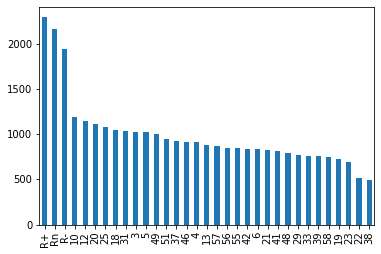

In [15]:
# Number of ratings per videoId
affect_ratings_matched_video_id["VideoId"].value_counts().plot.bar()

In [16]:
# Average ratings per video
df_results_avg_affect_per_video = affect_ratings_matched_video_id.groupby(['p_index_id','VideoId']).mean().reset_index()
df_results_avg_affect_per_video

,p_index_id,VideoId,participant_id,Valence,Arousal,RawX,RawY
0,0,3,101.0,1.000000,8.250000,46.500000,179.375000
1,0,4,101.0,1.000000,7.750000,65.250000,173.250000
2,0,6,101.0,3.076923,6.615385,100.000000,149.615385
3,0,10,101.0,1.619048,7.809524,67.428571,169.952381
4,0,12,101.0,1.000000,8.166667,51.333333,177.666667
...,...,...,...,...,...,...,...
1130,38,56,384.0,6.515152,5.727273,167.393939,135.696970
1131,38,57,384.0,6.576923,6.384615,166.269231,147.538462
1132,38,R+,384.0,4.967213,4.754098,135.114754,117.991803
1133,38,R-,384.0,4.886076,1.746835,136.367089,55.481013


In [17]:
matching_video_segment = affect_ratings_matched_video_id.groupby("VideoId").first()["Segment"]
matching_video_segment

VideoId
3     Negative
4     Negative
5     Negative
6     Negative
10    Negative
12    Negative
13    Negative
18    Negative
19    Negative
20    Negative
21     Neutral
22     Neutral
23     Neutral
25     Neutral
29     Neutral
31     Neutral
33     Neutral
37     Neutral
38     Neutral
39     Neutral
41    Positive
42    Positive
46    Positive
48    Positive
49    Positive
51    Positive
55    Positive
56    Positive
57    Positive
58    Positive
R+    Positive
R-    Negative
Rn     Neutral
Name: Segment, dtype: object

In [18]:
avg_aff = df_results_avg_affect_per_video.groupby(["VideoId"]).mean()[["Valence","Arousal"]].join(matching_video_segment).reset_index()
avg_aff["Segment"].iloc[ avg_aff["VideoId"].str.startswith("R").replace(np.nan, False) ] = "Rest"
avg_aff

c:\Program Files\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,VideoId,Valence,Arousal,Segment
0,3,2.925160,6.644785,Negative
1,4,2.537590,6.720390,Negative
2,5,3.555353,5.379763,Negative
3,6,3.085210,5.903473,Negative
4,10,3.144464,6.608573,Negative
5,12,3.427129,6.207243,Negative
6,13,2.617130,6.623608,Negative
7,18,3.227944,5.646558,Negative
8,19,2.666078,5.542982,Negative
9,20,3.049042,6.494111,Negative


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


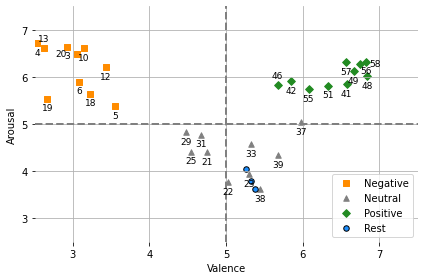

In [19]:
def generate_plot_affect_coordinates_ratings(df, ax):

    av_aff = df.copy()
    kwargs = {"Negative":{
                            "c":"darkorange", "marker":"s"
                            },
                    "Positive":{
                            "c":"forestgreen", "marker":"D"
                        },
                    "Neutral":{
                            "c":"grey", "marker":"^"
                        },
                    "Rest":{
                            "c":"dodgerblue", "marker":"o", "edgecolor":"k", "linewidths":1
                        }
                    }

    # colors = [kwargs[val]['c'] for val in avg_aff["Segment"]]
    # markers = [kwargs[val]['marker'] for val in avg_aff["Segment"]]
    # avg_aff.plot.scatter(ax=ax, x="Valence",y="Arousal",color=colors, markers=markers, legend=True)

    ax = plt.gca()
    # Plot
    offset_min = 2.5
    offset_max = 7.5
    ax.set(xlim=[offset_min,offset_max], ylim=[offset_min,offset_max])
    ax.set_xlabel("Valence")
    ax.set_ylabel("Arousal")
    # ax.set_title(f"Average Perceived Valence-Arousal ratings per video")

    ax.vlines([(offset_max+offset_min)/2], ymin=offset_min, ymax=offset_max, color="gray", linestyle='dashed', linewidth=2)
    ax.hlines([(offset_max+offset_min)/2], xmin=offset_min, xmax=offset_max, color="gray", linestyle='dashed', linewidth=2)
    ax.grid(True)
    ax.legend(loc="lower right")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    for segment in av_aff["Segment"].unique():
        df_test = av_aff[ (av_aff["Segment"] == segment)]
        avg_V = df_test["Valence"] #((df_test.sum_RawX/df_test.N)-128)/256 # Normalized affect between 0-1
        avg_A = df_test["Arousal"] #((df_test.sum_RawY/df_test.N)-128)/256

        ax.scatter( avg_V, avg_A, label=segment, s=30, **kwargs[segment] ) #c=colors[segment], s=80, marker=markers[segment])

        for i, videoId in enumerate(df_test["VideoId"].values):
            avg_V = df_test["Valence"]
            avg_A = df_test["Arousal"]

            # Defines where to offset the annotations depending on how many neighbors are there
            offsetX = 0.2
            offsetY = 0.2

            offset_dict = {
                0: [0, -offsetY],
                1: [0, offsetY],
                2: [-offsetX, 0],
                3: [offsetX, 0]
            }
            # Define offset based on how many points are close to the value
            # np.random.seed(345)
            # offset_annotation = offset_dict[np.floor(np.random.randint(4))] #offset_dict[0] #offset_dict[np.floor(np.random.randint(4))]
            thresh = 0.2
            radius = np.sqrt(np.abs(avg_A.iloc[i] - avg_A.iloc[:i])**2 + (np.abs(avg_V.iloc[i] - avg_V.iloc[:i])**2))
            n_close_neighbors = (radius<thresh).sum()
            offset_annotation = offset_dict[n_close_neighbors]

            # Annotate
            if(segment != "Rest"):
                ax.annotate(videoId, (avg_V.iloc[i]+offset_annotation[0], 
                                    avg_A.iloc[i]+offset_annotation[1]), 
                                    fontsize=9, ha='center', va='center',
                                    color='k')  #kwargs[segment]["c"])
    
    ax.grid(True)
    ax.legend(loc="lower right")

    return ax

# Plotting how each video was rated among all self-reported datapoints across all 15 participants.
save_path_plot = gen_path_plot("affect-coordinates-ratings-per-video")

NUM_ROWS = 1
NUM_COLS = 1
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(6*NUM_COLS, 4*NUM_ROWS))

axes = generate_plot_affect_coordinates_ratings(avg_aff, axes)

plt.tight_layout()
plt.savefig(save_path_plot)


### Statistical analysis tests

Validate whether the average self-reported **valence** and **arousal** ratings differ between video categories aiming to induce `Negative`, `Neutral`, and `Positive` affect.

**Method:** Paired t-test to compare the mean of two samples.

*Test 1*: $H_0: \mu_- \geq \mu_N$ | $H_1: \mu_- < \mu_N$

If $p<0.01$, we reject the null hypothesis that the mean **reported valence/arousal** in the `Negative` videos $\mu_-$ is *greater or equal*  than in the `Neutral` videos $\mu_N$

*Test 2*: $H_0: \mu_+ \leq \mu_N$ | $H_1: \mu_+ > \mu_N$

If $p<0.01$, we reject the null hypothesis that the mean **reported valence/arousal** in the `Positive` videos $\mu_-$ is *lower or equal* than in the `Neutral` videos $\mu_N$


**Conclusions**

Regarding *valence*, the mean ratings in the negative videos are significantly lower than the ratings in the neutral videos ($T=-11.22;N=10;p<0.01$). Similarly, the mean *valence* ratings in the positive videos are greater than in the neutral ($T=6.64;N=10;p<0.001$). Regarding arousal, the mean ratings in the positive videos are greater than in the neutral ($T=9.91;N=10;p<0.001$). However, the mean ratings in the positive videos are not significantly greater than the ratings in the neutral videos ($T=6.81;N=10;p=0.9$).

In [20]:
affect_ratings_matched_video_id

,p_index_id,participant_id,Session,Valence,Arousal,RawX,RawY,Segment,VideoId,Trigger
1,0,101,video_2,5,5,128,122,Positive,R+,End
2,0,101,video_2,6,5,149,127,Positive,R+,End
3,0,101,video_2,7,5,170,127,Positive,R+,End
4,0,101,video_2,8,5,193,126,Positive,R+,End
5,0,101,video_2,7,5,191,125,Positive,R+,End
...,...,...,...,...,...,...,...,...,...,...
35583,38,384,video_4,5,3,147,77,Positive,41,End
35584,38,384,video_4,5,4,143,93,Positive,41,End
35585,38,384,video_4,6,4,145,103,Positive,41,End
35586,38,384,video_4,7,4,161,101,Positive,41,End


In [21]:
# Replace columns as categorical to get all factors when grouping by
X = affect_ratings_matched_video_id.copy()
# X["p_index_id"] = pd.Categorical(X["p_index_id"], categories=X["p_index_id"].unique(), ordered=False)
# X["participant_id"] = pd.Categorical(X["participant_id"].astype(int), categories=X["participant_id"].unique().astype(int), ordered=False)
X["VideoId"] = pd.Categorical(X["VideoId"], categories=X["VideoId"].unique(), ordered=False)

In [22]:
# Generate DF with all participants and all videoIds (even if they have no ratings)
# result should be an array of 39 participants * 3 affect segments * (10+1) videos per segment = 1287
df_avg_per_participant_and_video = X.groupby(["p_index_id","VideoId"]).mean().reset_index().set_index(["VideoId"])
df_avg_per_participant_and_video

,p_index_id,participant_id,Valence,Arousal,RawX,RawY
VideoId,,,,,,
R+,0,101.0,6.586957,3.086957,164.565217,89.456522
49,0,101.0,5.562500,6.468750,147.593750,147.125000
46,0,101.0,6.800000,6.900000,171.400000,154.200000
41,0,101.0,7.750000,4.750000,191.250000,118.375000
48,0,101.0,8.272727,5.363636,206.363636,127.727273
...,...,...,...,...,...,...
42,38,384.0,6.000000,6.166667,155.000000,143.666667
51,38,NaN,NaN,NaN,NaN,NaN
18,38,384.0,2.851852,4.962963,91.555556,119.555556


In [23]:
# Generate a DF with summary affect ratings across participants, and join with corresponding affect segment
df_statistical_comparison = df_avg_per_participant_and_video.groupby("VideoId").mean().join(matching_video_segment).reset_index()
df_statistical_comparison["stage"] = "video"
df_statistical_comparison["stage"].iloc[ df_statistical_comparison["VideoId"].str.startswith("R").replace(np.nan, False) ] = "rest"

# Save file
STATISTICAL_TESTS_FILENAME = gen_path_results("1_AvgAffectRatingsPerVideoId", extension=".csv")
df_statistical_comparison.to_csv( STATISTICAL_TESTS_FILENAME, index=False)

df_statistical_comparison

c:\Program Files\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,VideoId,p_index_id,participant_id,Valence,Arousal,RawX,RawY,Segment,stage
0,R+,19.0,314.333333,5.380106,3.627818,142.515384,94.849119,Positive,rest
1,49,19.0,315.888889,6.664892,6.126926,168.042754,142.629690,Positive,video
2,46,19.0,310.333333,5.671792,5.828644,149.131776,136.989660,Positive,video
3,41,19.0,314.210526,6.573161,5.847535,167.393782,137.963389,Positive,video
4,48,19.0,316.093750,6.843087,6.011634,171.598356,139.996372,Positive,video
5,57,19.0,311.833333,6.565639,6.309483,167.096468,145.678304,Positive,video
6,56,19.0,316.297297,6.824453,6.328092,171.474719,145.624634,Positive,video
7,58,19.0,304.464286,6.745460,6.282918,170.328075,145.118006,Positive,video
8,55,19.0,314.500000,6.075956,5.734959,157.270185,134.685001,Positive,video
9,R-,19.0,315.800000,5.326414,3.789493,142.073991,98.266930,Negative,rest


**Valence**

We analyze `RawX` instead of `Valence` because it contains the raw reported values from the joystick and has not been quantisized in the `9-level` variable of valence.

In [24]:
# Just use the data from the videos, not the resting stages
df_comparisons = df_statistical_comparison[ df_statistical_comparison["stage"]=="video" ]
df_comparisons

,VideoId,p_index_id,participant_id,Valence,Arousal,RawX,RawY,Segment,stage
1,49,19.0,315.888889,6.664892,6.126926,168.042754,142.629690,Positive,video
2,46,19.0,310.333333,5.671792,5.828644,149.131776,136.989660,Positive,video
3,41,19.0,314.210526,6.573161,5.847535,167.393782,137.963389,Positive,video
4,48,19.0,316.093750,6.843087,6.011634,171.598356,139.996372,Positive,video
5,57,19.0,311.833333,6.565639,6.309483,167.096468,145.678304,Positive,video
6,56,19.0,316.297297,6.824453,6.328092,171.474719,145.624634,Positive,video
7,58,19.0,304.464286,6.745460,6.282918,170.328075,145.118006,Positive,video
8,55,19.0,314.500000,6.075956,5.734959,157.270185,134.685001,Positive,video
10,10,19.0,311.542857,3.144464,6.608573,101.254904,151.647997,Negative,video
11,13,19.0,313.210526,2.617130,6.623608,90.346304,151.517348,Negative,video


In [25]:
# Separate columns for statistical test
subj_valence_videos_neg = df_comparisons[df_comparisons["Segment"]=="Negative"]["RawX"]
subj_valence_videos_ntr = df_comparisons[df_comparisons["Segment"]=="Neutral"]["RawX"]
subj_valence_videos_pos = df_comparisons[df_comparisons["Segment"]=="Positive"]["RawX"]

print(f"N = {subj_valence_videos_neg.size}")

N = 10


In [26]:
print(f"Negative: \t{subj_valence_videos_neg.mean()} +/- ({subj_valence_videos_neg.std()})")
print(f"Neutral: \t{subj_valence_videos_ntr.mean()} +/- ({subj_valence_videos_ntr.std()})")
print(f"Positive: \t{subj_valence_videos_pos.mean()} +/- ({subj_valence_videos_pos.std()})")

Negative: 	98.02959270624305 +/- (6.758617657096512)
Neutral: 	138.67576415178218 +/- (8.865937435742328)
Positive: 	163.69917870723194 +/- (8.11508221003299)


negative < neutral

In [27]:
# Statistical test: paired t-test
test1 = stats.ttest_rel(subj_valence_videos_neg, subj_valence_videos_ntr, alternative="less")
print(test1)

Ttest_relResult(statistic=-11.223370960554844, pvalue=6.792985163699449e-07)


pos > neutral

In [28]:
test2 = stats.ttest_rel(subj_valence_videos_pos, subj_valence_videos_ntr, alternative="greater")
print(test2)

Ttest_relResult(statistic=6.643668872886332, pvalue=4.721029137574939e-05)


In [29]:
save_path_text = gen_path_results("1_Affect_Valence_Paired-T-Tests", extension=".txt")
f = open(save_path_text, "w")
f.write("Test 1: (H1) Negative < than Neutral:\t" + str(test1) + "\n")
f.write("Test 2: (H1) Positive > than Neutral:\t" + str(test2) + "\n")
f.close()

**Arousal**

Analyzing average value from `RawY` from the joystick

Conclusion: The `test1` rejects the possibility that negative is equal than neutral, and `test2` shows that positive videos are not equal than neutral.

In [30]:
# Separate columns for statistical test
subj_arousal_videos_neg = df_comparisons[df_comparisons["Segment"]=="Negative"]["RawY"]
subj_arousal_videos_ntr = df_comparisons[df_comparisons["Segment"]=="Neutral"]["RawY"]
subj_arousal_videos_pos = df_comparisons[df_comparisons["Segment"]=="Positive"]["RawY"]

print(f"Negative: \t{subj_arousal_videos_neg.mean()} +/- ({subj_arousal_videos_neg.std()})")
print(f"Neutral: \t{subj_arousal_videos_ntr.mean()} +/- ({subj_arousal_videos_ntr.std()})")
print(f"Positive: \t{subj_arousal_videos_pos.mean()} +/- ({subj_valence_videos_pos.std()})")

Negative: 	143.55283704999346 +/- (9.454596836654574)
Neutral: 	109.2581978169394 +/- (8.95376800038605)
Positive: 	140.37155023034336 +/- (8.11508221003299)


In [31]:
# Statistical test: paired t-test
test1 = stats.ttest_rel(subj_arousal_videos_neg, subj_arousal_videos_ntr, alternative="less")
print(test1)
test2 = stats.ttest_rel(subj_arousal_videos_pos, subj_arousal_videos_ntr, alternative="greater")
print(test2)

save_path_text = gen_path_results("1_Affect_Arousal_Paired-T-Tests", extension=".txt")
f = open(save_path_text, "w")
f.write("Test 1: (H1) Negative < than Neutral:\t" + str(test1) + "\n")
f.write("Test 2: (H1) Positive > than Neutral:\t" + str(test2) + "\n")
f.close()

Ttest_relResult(statistic=6.815496362043647, pvalue=0.9999611567529778)
Ttest_relResult(statistic=9.914398759998834, pvalue=1.921747364434939e-06)


### Boxplots average ratings per video

In [36]:
df_avg_affect_with_segment = df_avg_per_participant_and_video.join(matching_video_segment).reset_index()
df_avg_affect_with_segment

,VideoId,p_index_id,participant_id,Valence,Arousal,RawX,RawY,Segment
0,3,0,101.0,1.000000,8.250000,46.500000,179.375000,Negative
1,3,1,216.0,3.058824,7.117647,100.176471,162.617647,Negative
2,3,2,NaN,NaN,NaN,NaN,NaN,Negative
3,3,3,222.0,4.600000,7.200000,130.100000,159.450000,Negative
4,3,4,247.0,3.454545,7.500000,108.772727,174.045455,Negative
...,...,...,...,...,...,...,...,...
1282,Rn,34,370.0,4.942857,3.542857,134.142857,95.742857,Neutral
1283,Rn,35,379.0,5.525000,3.400000,144.225000,94.775000,Neutral
1284,Rn,36,381.0,4.652174,2.913043,130.521739,75.956522,Neutral
1285,Rn,37,382.0,8.000000,2.312500,188.812500,82.312500,Neutral


In [ ]:
def generate_plot_affect_boxplot_ratings(df_results, axis_to_plot, colname):
    ax = axis_to_plot
    # Sort groups
    df_avg_affect_2 = df_results.copy()
    df_avg_affect_2.sort_values(by=["VideoId"], inplace=True, key= lambda col: col.map(lambda item: ([str,int].index(type(item)), item) ) ) # Make letters come before numbers
    df_avg_affect_2.sort_values(by=["segment"], ascending=True, kind="mergesort", inplace=True) # Mergesort keeps respecting the previous sorting decision.

    # Rename columns
    df_avg_affect_2.rename( columns = {
                "Segment":"Exp. Segment",
                "VideoId": "Video ID",
                "Valence":"Avg. Valence",
                "Arousal":"Avg. Arousal"
                }, inplace = True )
    
    sns.set_theme(style="ticks")

    PALETTE_COLORS = ["darkorange" ,"dodgerblue","forestgreen", "gray"]

    # Vertical lines separating the experimental sessions
    ax.vlines([10.5, 21.5], ymin=1, ymax=9, color="black", linestyle='dotted', linewidth=1.5)

    # Filter the data that has to do with this column label
    sns.boxplot(data=df_avg_affect_2, ax=ax,
                x="Video ID", y=colname, hue="Exp. Segment", #orient="h",
                width=0.6, palette=PALETTE_COLORS, dodge =False,
                # notch=True, 
                showcaps=False,
                flierprops={"marker": "x"},
                boxprops={"edgecolor": "none"},
                # medianprops={"color": "coral"}
                )
    
    sns.despine(offset=10, trim=True)
    sns.move_legend(ax, loc="best", title=None, frameon=False)

    ax.set_ylabel(f"Affect Rating - {colname.split('.')[-1]}")
    ax.grid(axis="y")
    return ax

### Generate path to save and figure
save_path_plot = gen_path_plot(f"affect-boxplot-ratings-per-video")

NUM_ROWS = 1
NUM_COLS = 2
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(8*NUM_COLS, 5*NUM_ROWS))

COL_TITLES = ["Avg. Valence", "Avg. Arousal"]
for i in range(len(COL_TITLES)):
    axes[i] = generate_plot_affect_boxplot_ratings(df_avg_affect_with_segment, axes[i], COL_TITLES[i])

plt.tight_layout()
plt.savefig(save_path_plot)

---
## Load a postprocessed dataset

The following blocks generate a compiled dataset as the one created during the notebook `1_...ipynb`. It contains a subset from the DRAP dataset with the relevant columns, synchronized events with physiological data, and resampled at 50Hz.

In [ ]:
# Load the dataset
DATASET_POSTPROCESSED_FILENAME = "./temp/DRAP_1_preprocess/Dataset_DRAP_postprocessed.csv"
DATASET_POSTPROCESSED_FILENAME

In [ ]:
# Load the file in memory (~700MB)
dataset = pd.read_csv(DATASET_POSTPROCESSED_FILENAME)

In [ ]:
dataset.columns

### General variables

The following variables store important info about the dataset. How many participants? Which video segments are included? Which videoIds are contained in each affective segment?

In [ ]:
participants_ids = dataset["Participant"].unique()
participants_ids

In [ ]:
experiment_segment_names = dataset["Stage"].unique()
experiment_segment_names

In [ ]:
video_ids = dataset["VideoId"].unique()
print(np.sort(video_ids))
# -1 refers to the resting stages, no video is presented.

In [ ]:
# All rows inside the `video` stage should contain a VideoId differen than -1,
# As -1 denotes a resting video. The following code verifies that there are no invalid rows.
# NOTE: The result should be and empty DF.
Q = (( dataset["VideoId"]==-1) & ~(dataset["Stage"].str.startswith("Resting_")))
dataset[Q]

In [ ]:
# Generate a dictionary with the stage and their corresponding list of `VideoId`
# Confirm the unique Video IDs in each experimental segment
video_ids_per_segment = {}
for segment in experiment_segment_names:
    video_ids_per_segment[segment] = np.array([])
    # Keep unique video ids
    Q = ( dataset["Stage"] == segment )
    video_ids_per_segment[segment] = dataset[Q]["VideoId"].unique()
video_ids_per_segment

In [ ]:
# The index is in the order ["Participant", "AffectSegment", "Time"]
# It allows multidimensional manipulation in a 2D pandas structure
data = dataset.set_index(["Participant","Stage","Time"])
data.sort_index(inplace=True)
data.head()

In [ ]:
# PARTICIPANT_IDX = 0
# EXPERIMENTAL_SEGMENT = "Positive"
# # Access the dictionary of videos existing in the segment, choose the first VideoID
# VIDEO_ID = video_ids_per_segment[EXPERIMENTAL_SEGMENT][0] 

# ##
# # Select a whole experimental segment
# single_segment_ts = data.loc[(PARTICIPANT_IDX,EXPERIMENTAL_SEGMENT)]
# # Select a specific video inside the experimental segment
# single_video_ts = single_segment_ts[ single_segment_ts["VideoId"] == VIDEO_ID]

Combining both images

In [ ]:
# # Join image
# save_path_plot = gen_path_plot(f"affect-ratings-per-video")

# NUM_ROWS = 1
# NUM_COLS = 3

# fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(7*NUM_COLS, 4*NUM_ROWS))

# axes[0] = generate_plot_affect_coordinates_ratings(axes[0], offset=[1,9])
# axes[1] = generate_plot_affect_boxplot_ratings(axes[1], COL_TITLES[0])
# axes[2] = generate_plot_affect_boxplot_ratings(axes[2], COL_TITLES[1])

# # plt.suptitle(f"Average over all {participants_ids.size} participants.")
# plt.tight_layout()
# plt.savefig(save_path_plot)
# print(f"Average over all {participants_ids.size} participants.")

---
## Load a postprocessed dataset

The following blocks generate a compiled dataset as the one created during the notebook `1_...ipynb`. It contains a subset from the DRAP dataset with the relevant columns, synchronized events with physiological data, and resampled at 50Hz.

In [ ]:
# Load the dataset
DATASET_POSTPROCESSED_FILENAME = "./temp/DRAP_1_preprocess/Dataset_DRAP_postprocessed.csv"
DATASET_POSTPROCESSED_FILENAME

In [ ]:
# Load the file in memory (~700MB)
dataset = pd.read_csv(DATASET_POSTPROCESSED_FILENAME)

In [ ]:
dataset.columns

### General variables

The following variables store important info about the dataset. How many participants? Which video segments are included? Which videoIds are contained in each affective segment?

In [ ]:
participants_ids = dataset["Participant"].unique()
participants_ids

In [ ]:
experiment_segment_names = dataset["Stage"].unique()
experiment_segment_names

In [ ]:
video_ids = dataset["VideoId"].unique()
print(np.sort(video_ids))
# -1 refers to the resting stages, no video is presented.

In [ ]:
# All rows inside the `video` stage should contain a VideoId differen than -1,
# As -1 denotes a resting video. The following code verifies that there are no invalid rows.
# NOTE: The result should be and empty DF.
Q = (( dataset["VideoId"]==-1) & ~(dataset["Stage"].str.startswith("Resting_")))
dataset[Q]

In [ ]:
# Generate a dictionary with the stage and their corresponding list of `VideoId`
# Confirm the unique Video IDs in each experimental segment
video_ids_per_segment = {}
for segment in experiment_segment_names:
    video_ids_per_segment[segment] = np.array([])
    # Keep unique video ids
    Q = ( dataset["Stage"] == segment )
    video_ids_per_segment[segment] = dataset[Q]["VideoId"].unique()
video_ids_per_segment

In [ ]:
# The index is in the order ["Participant", "AffectSegment", "Time"]
# It allows multidimensional manipulation in a 2D pandas structure
data = dataset.set_index(["Participant","Stage","Time"])
data.sort_index(inplace=True)
data.head()

## EDA
Exploratory Data Analysis (EDA) to visualize a particular experimental segment from a specific participant

In [ ]:
PARTICIPANT_IDX = 0
EXPERIMENTAL_SEGMENT = "Positive"
# Access the dictionary of videos existing in the segment, choose the first VideoID
VIDEO_ID = video_ids_per_segment[EXPERIMENTAL_SEGMENT][0] 

##
# Select a whole experimental segment
single_segment_ts = data.loc[(PARTICIPANT_IDX,EXPERIMENTAL_SEGMENT)]
# Select a specific video inside the experimental segment
single_video_ts = single_segment_ts[ single_segment_ts["VideoId"] == VIDEO_ID]

In [ ]:
single_segment_ts.plot.line(subplots=True, figsize=(15,1*single_segment_ts.shape[1]), sharex=True)

In [ ]:
single_video_ts.plot.line(subplots=True, figsize=(5,1*single_video_ts.shape[1]), sharex=True)

---
## Analysis 2: Feature-based classification assuming independent samples

Feature-based classification assuming that the features captured with overlapping windows act as independent samples, unlike in time-series classification.

Feature extraction steps:
1. Traverse the time-series data per participant and per experimental segment: (~300secs per video segment).
2. Consider the following stages as target classes: `[Positive, Neutral, Positive]`.
3. Take the corresponding resting stages ( `[Resting_Negative, Resting_Neutral, Resting_VideoPositive]`) to fit a standardizer ($\mu=0,\sigma=1$)
4. Apply a sliding window of width `30sec` with overlap `7.5s` to extract **statistical features** (11 features per dimension) from: `[HEART, MOTOR, FACE]`.
5. In addition, calculate **time-domain HRV features** from the non-standardized version of the PPG signal (5 features from PPG).

In [ ]:
ORIG_SAMP_FREQUENCY_HZ = 50

WINDOW_WIDTH_SECS = 30
WINDOW_OVERLAP_SECS = 10

In [ ]:
# Copy the original dataset again
data = dataset.copy().set_index(["Participant","Stage","Time"])
data.sort_index(inplace=True)
data.head()

In [ ]:
# Identify groups of features
basic_colnames = drap.preprocessing.COLNAMES_AFFECT
hrv_colnames = drap.preprocessing.COLNAMES_HR + drap.preprocessing.COLNAMES_PPG
imu_colnames = drap.preprocessing.COLNAMES_ACCELEROMETER + drap.preprocessing.COLNAMES_MAGNETOMETER + drap.preprocessing.COLNAMES_GYROSCOPE
emg_colnames = drap.preprocessing.COLNAMES_EMG_AMPLITUDE

In [ ]:
# Identify colnames that have relevant time-series data (exclude videoId, affect, etc.)
TS_DATA_COLNAMES = hrv_colnames + imu_colnames + emg_colnames

In [ ]:
def filter_outliers_from_df(df, num_std = 5):
    """
    Takes a multidimensional dataFrame and filter the values
    that are `num_std` standard deviations away from the mean value
    of the column.

    First, it transforms the value in np.nan. Then, it imputes the
    value with backward filling, and then with forward filling, in case
    the missing values are generated on the extremes of the time-series.

    Returns the filtered dataset
    """
    mask = (( df > (df.mean() + num_std*df.std())) | ( df < (df.mean() - num_std*df.std())) )
    df[ mask ] = np.nan
    df_filtered = df.fillna(method="backfill", axis=0)
    df_filtered = df_filtered.fillna(method="ffill", axis=0)
    print(f"\tTotal NAs --> Generated={df.isna().sum().sum()} - After imputation={df_filtered.isna().sum().sum()}")
    return df_filtered

*Testing feature extraction in one instance*...

In [ ]:
# INSTANCE
PARTICIPANT_IDX = 1
EXP_SEGMENT = str(drap.preprocessing.AffectSegments.VideosPositive)
VIDEO_ID = video_ids_per_segment[EXP_SEGMENT][0]

print(f"participant={PARTICIPANT_IDX}, segment={EXP_SEGMENT}, video_id={VIDEO_ID}")

**Preparing resting stage as baseline for the scaler**

In [ ]:
# Read from dataset data from a VIDEO segment and its corresponding RESTING stage
single_segment_ts = data.loc[(PARTICIPANT_IDX,EXP_SEGMENT)]
single_segment_ts = single_segment_ts[TS_DATA_COLNAMES] # Choose columns with relevant data

# This resting stages will be used to normalize the values.
single_segment_resting = data.loc[(PARTICIPANT_IDX,"Resting_"+EXP_SEGMENT)]

print(f"Video df shape: {single_segment_ts.shape}")
print(f"Resting df shape: {single_segment_resting.shape}")

In [ ]:
# Scaler fitted on resting stage
scaler = ColumnTransformer( [ 
                            ("", StandardScaler(), TS_DATA_COLNAMES) # Apply to all columns with TS data
                        ])
scaler.fit(single_segment_resting)

**Sliding window to iterate over the signal**

In [ ]:
def generate_sliding_windows(df_ts, 
                        window_width_seconds,
                        window_overlap_seconds,
                        verbose = False
                        ):
    """
    Iterates over the dataframe in `df_ts` with overlapping windows
    defined by `window_width_seconds` and `window_overlap_seconds`.

    This function assumes that the index of `df_ts` is in seconds
    and is sorted incrementally.
    Returns a list of tuples with the (start,end) of each window
    """
    # Generate iterator
    w_start_indices = np.arange(df_ts.index[0], df_ts.index[-1], window_overlap_seconds)
    return [ (w, w+window_width_seconds) for w in w_start_indices ]


In [ ]:
generate_sliding_windows(single_segment_ts,
                        window_overlap_seconds = WINDOW_OVERLAP_SECS,
                        window_width_seconds = WINDOW_WIDTH_SECS)

In [ ]:
# Select first window
df_window = single_segment_ts.loc[0:WINDOW_WIDTH_SECS]
df_window.head()

**Extract HRV features from PPG**

In [ ]:
def calculate_hrv_features(df_ppg, sampling_frequency, return_plot=False):
    """
    Receives a dataframe with ppg data and returns
    time-domain features.
    """
    signals, info = nk.ppg_process(df_ppg, sampling_rate=sampling_frequency)
    peaks = signals.PPG_Peaks

    ## Plot summary
    # nk.ppg_plot(signals, sampling_rate=ORIG_SAMP_FREQUENCY_HZ)

    # Time-based features
    hrv_time = nk.hrv_time(peaks, sampling_rate=sampling_frequency, show=False)

    # `TODO: See HRV_time() from drap utils.`

    # HRV features from neurokit2 that should be forwarded for final dataset
    HRV_SUBSET_FEATURES = ["HRV_MeanNN","HRV_SDNN","HRV_RMSSD","HRV_MedianNN", "HRV_IQRNN"]
    hrv_time_features = hrv_time[ HRV_SUBSET_FEATURES ]

    # ## NOTE: Frequency features are not used because the window width may not enough for most features!
    # hrv_freq = nk.hrv_frequency(peaks, sampling_rate=ts_sampling_freq, show=True, normalize=True)
    # hrv_allfeatures = nk.hrv(peaks, sampling_rate=ts_sampling_freq, show=True)

    #### Save figure when `show=True`
    # save_path_plot = gen_path_plot(f"Preprocessing/PPG/Participant{participant}_{segment}")
    # fig = plt.gcf().set_size_inches(8, 5)
    # plt.tight_layout()
    # plt.savefig(save_path_plot)
    # plt.close()
    return hrv_time_features


# `TODO:`

- Fix: Check HRV_TIim
- Check a way to filter PPG s reliability - FitState? FacePlate? ProximitY?
- 

In [ ]:
PPG_COLNAME = 'Ppg/Raw.ppg'     
calculate_hrv_features(df_window[PPG_COLNAME], ORIG_SAMP_FREQUENCY_HZ)

**Extract statistical features**

In [ ]:
def calculate_statistical_features(df):
    """
    Calculates the following features per column in the dataframe,
    adding a suffix for each processed column:
        - mean:     mean
        - std:      standard devaition
        - min:      minimum value
        - max:      maximum value
        - median:   median
        - irq:      interquartile range
        - pnv:      proportion of negative values
        - ppv:      proportion of positive values
        - skew:     skewness of the distribution
        - kurt:     kurtosis of the distribution
        - energy:   sum of squared absolute values
    """

    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)

    FUNCTIONS_FEATURES = {
        "mean":     np.mean,
        "std":      np.std,
        "min":      np.min,
        "max":      np.max,
        "median":   np.median,
        "irq":      stats.iqr,
        "pnv":      (lambda y: y[y<0].size/y.size),
        "ppv":      (lambda y: y[y>0].size/y.size),
        "skew":     stats.skew,
        "kurt":     stats.kurtosis,
        "energy":   (lambda y: np.sum(np.abs(y)**2) ),
    }
    
    # Store results with features per columns
    df_features_results = { }

    for feat_name,feat_func in FUNCTIONS_FEATURES.items():
        for col_name in list(df.columns):
            df_features_results[f"{col_name}_{feat_name}"] = [ feat_func(df[col_name]) ]

    return pd.DataFrame(df_features_results)

In [ ]:
# Apply standardization on the VIDEO experimental stage
# Normalize the data from each participant w.r.t to the same variable during the corresponding resting stage.
df_window_norm = pd.DataFrame(data = scaler.transform(df_window), 
                                                columns = TS_DATA_COLNAMES, 
                                                index = df_window.index)

""" Create statistical feature """
statistical_features = calculate_statistical_features(df_window_norm)
statistical_features

In [ ]:
print(statistical_features.columns.values)

In [ ]:
def extract_features_from_ts_window(data_df_window, ts_sampling_freq:float,
                                    colname_ppg:str,
                                    fitted_scaler:object,
                                    columns_to_normalize:list):
    """
    Takes a dataframe and extracts HRV and summary features from it
    Returns a dataframe with one row combining all features.
    """
    df_window = data_df_window
    
    # Extract HRV features from PPG
    hrv_time_features = calculate_hrv_features(df_window[colname_ppg], ts_sampling_freq)
    
    """ Create statistical feature """
    # Apply standardization on the VIDEO experimental stage
    # Normalize the data from each participant w.r.t to the same variable during the corresponding resting stage.
    df_window_norm = pd.DataFrame(data = fitted_scaler.transform(df_window), 
                                                    columns = columns_to_normalize, 
                                                    index = df_window.index)
    
    statistical_features = calculate_statistical_features(df_window_norm)

    df_result = pd.concat([hrv_time_features, statistical_features], axis=1)
    return df_result

In [ ]:
extract_features_from_ts_window(single_segment_ts, ORIG_SAMP_FREQUENCY_HZ,
                                PPG_COLNAME, scaler,
                                columns_to_normalize=TS_DATA_COLNAMES)

### Applying feature extraction to all data

In [ ]:
FEATURE_BASED_DATASET_FILENAME = gen_path_temp("Dataset_DRAP_ManualFeaturesHRVandStatistics", extension=".csv")

df_feature_extraction = None

if (os.path.isfile(FEATURE_BASED_DATASET_FILENAME)):
    df_feature_extraction = pd.read_csv(FEATURE_BASED_DATASET_FILENAME)
else:
    # Iterate over participants
    for participant in participants_ids:
        # Iterate over segments
        for segment in [ str(x) for x in drap.preprocessing.utils.enums.AffectSegments]:

            """ Load data from RESTING stages to standardize the data during VIDEO"""
            # Extract data from RESTING stage
            single_segment_resting = data.loc[(participant,"Resting_"+segment)]
            single_segment_resting = single_segment_resting[ TS_DATA_COLNAMES ]

            # Filter datapoints that are larger than N*std
            single_segment_resting = filter_outliers_from_df(single_segment_resting)

            # Standardizer per column over data in the resting stage
            scaler = ColumnTransformer( [ 
                                        ("", StandardScaler(), TS_DATA_COLNAMES) # Apply to all columns with TS data
                                    ])
            scaler.fit(single_segment_resting)

            """ Load data from VIDEO stage and filter it  """
            # Extract data from VIDEO stage
            single_segment_ts = data.loc[(participant,segment)]
            single_segment_ts = single_segment_ts[ TS_DATA_COLNAMES ]
            
            # Filter datapoints that are larger than N*std
            single_segment_ts = filter_outliers_from_df(single_segment_ts)

            """ Generate indices for sliding windows """
            window_indices = generate_sliding_windows(single_segment_ts,
                                                window_width_seconds = WINDOW_WIDTH_SECS,
                                                window_overlap_seconds = WINDOW_OVERLAP_SECS,
                                                verbose=True)

            # Iterator to generate sliding windows
            for w_counter, (w_start, w_end) in enumerate(window_indices):
                df_window = single_segment_ts.loc[w_start:w_end]

                # To avoid non-complete window sizes. 
                # Analyze the window if the number of samples is >95% of expected number of samples
                if(df_window.shape[0] < 0.95*WINDOW_WIDTH_SECS*ORIG_SAMP_FREQUENCY_HZ):
                    print(f"Skipping window: Fewer samples than expected in [{w_start},{w_end}] - Samples: {df_window.shape[0]}<95%*{WINDOW_WIDTH_SECS*ORIG_SAMP_FREQUENCY_HZ}")
                    continue
            
                # DataFrame with general information and target class in "segment"
                df_this_feature_extraction = pd.DataFrame({
                                                "participant":  [participant],
                                                "segment":      [segment],
                                                "i_window":     [w_counter],
                                            })
                
                """ Extract HRV and statistical features from window """
                all_features = extract_features_from_ts_window(single_segment_ts, 
                                                                ORIG_SAMP_FREQUENCY_HZ,
                                                                PPG_COLNAME, scaler,
                                                                columns_to_normalize=TS_DATA_COLNAMES)

                """ Create final feature vector for the window"""
                df_this_feature_extraction = pd.concat([df_this_feature_extraction, all_features], axis=1)
                
                df_feature_extraction = df_this_feature_extraction if (df_feature_extraction is None) else pd.concat([df_feature_extraction, df_this_feature_extraction], axis=0, ignore_index=True)


                # Saving .csv
                df_feature_extraction.to_csv( FEATURE_BASED_DATASET_FILENAME, index=False)

                """ Save plots with HRV features """
                        
                # # Save HRV features plot
                # save_path_plot = gen_path_plot(f"Features/Participant{participant}/HRV_{segment}_w{w}")
                # fig = plt.gcf().set_size_inches(8, 5)
                # plt.tight_layout()
                # plt.savefig(save_path_plot)
                # plt.close(fig)

                # # Save PPG plot
                # save_path_plot = gen_path_plot(f"Features/Participant{participant}/PPG_{segment}_w{w}")
                # nk.ppg_plot(signals, sampling_rate=ORIG_SAMP_FREQUENCY_HZ)
                # fig = plt.gcf().set_size_inches(8, 5)
                # plt.tight_layout()
                # plt.savefig(save_path_plot)
                # plt.close(fig)

                # # # Save statistical features plot - TAKES TOO LONG!
                # # save_path_plot = gen_path_plot(f"Features/Participant{participant}/{segment}_{w}_ALL")
                # # statistical_features.plot(subplots=True,figsize=(10,2*statistical_features.shape[1]))
                # # plt.savefig(save_path_plot)
                # # plt.close(fig)

        # df_feature_extraction.reset_index(drop=True, inplace=True)
    print("\n\n End")

In [ ]:
# Save a LARGE figure with all the features
df_feature_extraction.plot(subplots=True,figsize=(3*participants_ids.size,2*df_feature_extraction.shape[1]))
save_path_plot = gen_path_plot(f"features/_ALL")
# plt.savefig(save_path_plot)
# plt.close()

In [ ]:
# RELOAD_TRIES = 3
    
# # Where the compiled dataset will be stored
# FEATURE_BASED_DATASET_FILENAME = gen_path_temp("Dataset_DRAP_ManualFeaturesHRVandStatistics", extension=".csv")

# # DF containing the final dataframe for classification
# df_feature_extraction = None

# ### INPUTS / OUTPUTS
# """EDIT CUSTOM FILENAMES"""
# input_files = [FEATURE_BASED_DATASET_FILENAME]

# # Try to load files maximum two times
# for tries in range(RELOAD_TRIES):
#     try:
#         ### LOAD FILE
#         print(f"Trying {tries+1}/{RELOAD_TRIES} to load files: {input_files}")
        
#         ### CUSTOM SECTION TO READ FILES
#         """EDIT CUSTOM READ"""
#         df_feature_extraction = pd.read_csv(input_files[0])
#         print(f"File {input_files[0]} was successfully loaded")

#     except Exception as e:
#         ### CREATE FILE
#         print(f"File not found. Creating again! {e}")

#         ### CUSTOM SECTION TO CREATE FILES 
#         """EDIT CUSTOM WRITE"""

#         # Iterate over participants
#         for participant in participants_ids:
#             # Iterate over segments
#             for segment in ["VideoNegative", "VideoPositive"]:

#                 """ Take the data from RESTING stages to standardize the data during VIDEO"""
#                 # Extract data from RESTING stage
#                 single_segment_resting = data.loc[(participant,"Resting_"+segment)]
#                 single_segment_resting = single_segment_resting[ TS_DATA_COLNAMES ]

#                 # Filter datapoints that are larger than N*std
#                 single_segment_resting = filter_outliers_from_df(single_segment_resting)

#                 # Standardizer per column over data in the resting stage
#                 scaler = ColumnTransformer( [ 
#                                             ("", StandardScaler(), TS_DATA_COLNAMES) # Apply to all columns with TS data
#                                         ])
#                 scaler.fit(single_segment_resting)

#                 """ Create overlapping windows """
#                 # Extract data from VIDEO stage
#                 single_segment_ts = data.loc[(participant,segment)]
#                 single_segment_ts = single_segment_ts[ TS_DATA_COLNAMES ]
                
#                 # Filter datapoints that are larger than N*std
#                 single_segment_ts = filter_outliers_from_df(single_segment_ts)

                

#                 # Iterator to generate sliding windows
#                 for w, window_start in enumerate(np.arange(0, single_segment_ts.index[-1], WINDOW_OVERLAP_SECS)):
#                     window_end = window_start + WINDOW_WIDTH_SECS
#                     df_window = single_segment_ts.loc[window_start:window_end]

#                     # To avoid non-complete window sizes. 
#                     # Analyze the window if the number of samples is >95% of expected number of samples
#                     if(df_window.shape[0] >= 0.95*WINDOW_WIDTH_SECS*ORIG_SAMP_FREQUENCY_HZ):
#                         # print(window_start, window_end, df_window.shape)

#                         # DataFrame with general information and target class in "segment"
#                         df_this_feature_extraction = pd.DataFrame({
#                                                         "participant":  [participant],
#                                                         "segment":      [segment],
#                                                         "i_window":     [w],
#                                                     })

#                         """ Extract HRV features from original data window"""
#                         # Extract HRV features from PPG
#                         ppg = df_window.PPG
#                         signals, info = nk.ppg_process(ppg, sampling_rate=ORIG_SAMP_FREQUENCY_HZ)
#                         peaks = signals.PPG_Peaks
#                         hrv_time = nk.hrv_time(peaks, sampling_rate=ORIG_SAMP_FREQUENCY_HZ, show=True) # NOTE: Change `show=True` if uncommenting before
#                         hrv_time_features = hrv_time[ HRV_SUBSET_FEATURES ]
#                         ### NOTE: Frequency features are not used because 15sec window is not enough for most features!
#                         # hrv_freq = nk.hrv_frequency(peaks, sampling_rate=ORIG_SAMP_FREQUENCY_HZ, show=True, normalize=True)
#                         # hrv_allfeatures = nk.hrv(peaks, sampling_rate=ORIG_SAMP_FREQUENCY_HZ, show=True)

#                         """ Apply standardization to the data from the window """
#                         # Extract data from experimental segment
#                         df_window = df_window       ## Where the data is contained
#                         # Apply standardization on the VIDEO experimental stage
#                         # Normalize the data from each participant w.r.t to the same variable during the corresponding resting stage.
#                         df_window_norm = pd.DataFrame(data = scaler.transform(df_window), 
#                                                                         columns = TS_DATA_COLNAMES, 
#                                                                         index = df_window.index)

#                         """ Create statistical feature """
#                         statistical_features = calculate_statistical_features(df_window_norm)

#                         """ Create final feature vector for the window"""
#                         df_this_feature_extraction = pd.concat([df_this_feature_extraction, hrv_time_features, statistical_features], axis=1)

#                         df_feature_extraction = df_this_feature_extraction if (df_feature_extraction is None) else pd.concat([df_feature_extraction, df_this_feature_extraction], axis=0)


#                         """ Save plots with HRV features """
                                
#                         # Save HRV features plot
#                         save_path_plot = gen_path_plot(f"Features/Participant{participant}/HRV_{segment}_w{w}")
#                         fig = plt.gcf().set_size_inches(8, 5)
#                         plt.tight_layout()
#                         plt.savefig(save_path_plot)
#                         plt.close(fig)

#                         # Save PPG plot
#                         save_path_plot = gen_path_plot(f"Features/Participant{participant}/PPG_{segment}_w{w}")
#                         nk.ppg_plot(signals, sampling_rate=ORIG_SAMP_FREQUENCY_HZ)
#                         fig = plt.gcf().set_size_inches(8, 5)
#                         plt.tight_layout()
#                         plt.savefig(save_path_plot)
#                         plt.close(fig)

#                         # # Save statistical features plot - TAKES TOO LONG!
#                         # save_path_plot = gen_path_plot(f"Features/Participant{participant}/{segment}_{w}_ALL")
#                         # statistical_features.plot(subplots=True,figsize=(10,2*statistical_features.shape[1]))
#                         # plt.savefig(save_path_plot)
#                         # plt.close(fig)

#             df_feature_extraction.reset_index(drop=True, inplace=True)
        
#         """ Save large figure visualizing all the new dataset"""
#         # Save a LARGE figure with all the features
#         save_path_plot = gen_path_plot(f"Features/_ALL")
#         df_feature_extraction.plot(subplots=True,figsize=(3*participants_ids.size,2*df_feature_extraction.shape[1]))
#         plt.savefig(save_path_plot)
#         plt.close()

#     # Saving .csv
#     df_feature_extraction.to_csv( input_files[0], index=False)
#     print("\n\n End")
    
#     # Finish iteration
#     break

---
## Analysis 3: Classification

- Select subset of features: `[Cardiac, Motor, Facial]`
- Configure the train-test strategy for CV with [Leave-One-Subject-Out (LOSO)](https://scikit-learn.org/stable/modules/cross_validation.html#leave-one-group-out)
- 

In [ ]:
data_X = df_feature_extraction.drop(["segment"], axis=1)
data_X

In [ ]:
data_Y = df_feature_extraction["segment"].map(CLASSES_MAPPING)
data_Y.value_counts().plot.barh()

In [ ]:
data_participant = df_feature_extraction.participant
data_participant.value_counts().plot.bar()

### Feature selection per data modality

In [ ]:
hrv_colnames = data_X.columns[ [ (col.startswith("HR")| col.startswith("PPG")) for col in data_X.columns] ].sort_values().values
hrv_colnames

In [ ]:
imu_colnames = data_X.columns[ [ (col.startswith("ACC")) for col in data_X.columns] ].sort_values().values
imu_colnames

In [ ]:
emg_colnames = data_X.columns[ [ (col.startswith("EMG")) for col in data_X.columns] ].sort_values().values
emg_colnames

### Correlation plots

Standardize [$\mathcal{N}(0,1)$] each of the column features and map the correlation among variables and vs. target variable `segment`.

*Generating these images take about >3h if facial features are included*

In [ ]:
# # Test plot
# save_path_plot = gen_path_plot(f"Features/_CorrelationPlot_test")
# df_plot = df_feature_extraction[hrv_colnames[:5]]
# df_plot = pd.DataFrame(data=StandardScaler().fit_transform(df_plot), 
#                         columns=df_plot.columns, 
#                         index=df_plot.index)
# sns.pairplot(pd.concat([data_Y, df_plot], axis=1),
#                 kind="reg",
#                 diag_kind="kde")
# plt.savefig(save_path_plot)

In [ ]:
# Name and columns of the corresponding data modalities
corr_plots_config = {
    "hrv": hrv_colnames,
    "imu": imu_colnames,
    "emg": emg_colnames,
}

for k,v in corr_plots_config.items():
    # Select subfeatures from large dataset
    df_plot = df_feature_extraction[v]
    # Standardize the features (but not the target)
    df_plot = pd.DataFrame(data=StandardScaler().fit_transform(df_plot), 
                            columns=df_plot.columns, 
                            index=df_plot.index)
    # Concatenate target and features from the specific modality
    df_plot = pd.concat([data_Y, df_plot],axis=1)

    #### SNS Pairplot - Takes a long time!! Around 3 hours for facial features. 10 mins for others!
    # # save_path_plot = gen_path_plot(f"Features/_PairPlot_{k}")
    # # sns.pairplot(df_plot, kind="reg", diag_kind="kde")
    # # plt.savefig(save_path_plot)
    # # plt.close()

    # Generate correlation plot and save DataFrame as HTML (it's not a matplotlib Figure)
    save_path_plot = gen_path_plot(f"Features/_CorrelationPlot_{k}", extension=".html")
    corr = df_plot.corr()
    corr_style = corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)
    corr_style.to_html(save_path_plot)


### Classification models

Important reading:
- [Common pitfalls in the interpretation of coeffs in linear models.](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#sphx-glr-auto-examples-inspection-plot-linear-model-coefficient-interpretation-py)

Methods to compare:
- **Linear SVM with Lasso Regularization:** The L1-regularization tends to prefer solution with fewer non-zero coefficients compared to L2 (Ridge) regression, thus reducing the number of features upon which the given solution is dependent. As we intend to highlight the most important features, we use this regression as a baseline method.
- *Others in the variable `classifiers_hyperparams`*


*Testing Classification pipeline*

In [ ]:
## Example of iterator for Cross-validation per subject

# Feature subset
feature_subset_colnames = hrv_colnames   # imu_colnames, emg_colnames

# Features
x = data_X[feature_subset_colnames]
# Target
y = data_Y
# Groups indices (participants' ids)
group_cv = data_participant

loso_cv = LeaveOneGroupOut()
cv_splits = loso_cv.split(x, y, groups=group_cv)
for trn_idx, tst_idx in cv_splits:
    print("TRN: %s \t TST: %s" % (data_participant[trn_idx].unique(), data_participant[tst_idx].unique()))

### Apply classification task

In [ ]:
data_modality_colnames = { 
            "hrv": hrv_colnames, 
            "imu": imu_colnames, 
            "emg": emg_colnames,
            "all": list(hrv_colnames) + list(imu_colnames) + list(emg_colnames),
    }

# ClassifierName: {"clf":model, "pgrid":parameters)
classifiers_hyperparams = {
    # "LinearLasso": {    "clf": Lasso(alpha=0.01, max_iter=10000),
    #                     "pgrid": {'alpha': np.logspace(-5, 5,11) }},
    "LinearRidge": {    "clf": RidgeClassifier(alpha=0.01, max_iter=1000),
                        "pgrid": {'alpha': np.logspace(-5, 5,11) }},
    "LinearSVM": {      "clf": LinearSVC(C = 1, penalty="l1", dual=False, max_iter=20000),
                        "pgrid": {'C': [1, 10, 100, 1000]}},
    "GaussianSVM": {    "clf": SVC(kernel='rbf', gamma='auto', C = 1),
                        "pgrid": {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}},
    "RF": {             "clf": RandomForestClassifier(criterion='entropy', random_state=experiment_config.MC_RANDOM_SEED),
                        "pgrid": {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 20]}},
    # "KNN": {            "clf": KNeighborsClassifier(),
    #                     "pgrid": {'n_neighbors': [3, 5, 7, 13, 15]}},
    # "GBM": {            "clf": GradientBoostingClassifier(criterion='friedman_mse', random_state=experiment_config.MC_RANDOM_SEED),
    #                     "pgrid": {'n_estimators': [10, 20, 50], 'max_depth': [5, 10, 20]}},
    }

In [ ]:

# Where the compiled dataset will be stored
MODEL_TRAINING_RESULTS_FILENAME = gen_path_results("2_Results_ModelTrainingCV_PerModalityPerSubject", extension=".csv")

# Load or create dataframe with results
df_results_hyperparam_opt = None


### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [MODEL_TRAINING_RESULTS_FILENAME]

# Try to load files maximum two times
for tries in range(RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        df_results_hyperparam_opt = pd.read_csv(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")
        break

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")
        
        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""


        #### ITERATION FOR THE EXPERIMENT
        ## Iteration per data type
        for modality_name, modality_colnames in data_modality_colnames.items(): 
            # modality_name = "hrv"
            # modality_colnames = data_modality_colnames[modality_name]
            #### ABOVE FOR TESTING

            # Subset of features
            data_mod_x = data_X[modality_colnames].values.copy()   # Features
            data_mod_y = data_Y.values.copy()       # Target
            subject_ids = data_participant.values.copy()  # Groups indices (participants' ids)

            # Split dataset with LOSO-CV
            cv_loso_subj = LeaveOneGroupOut()
            cv_splits_subjects = cv_loso_subj.split(data_mod_x, data_mod_y, groups=subject_ids)

            # Iteration per subject (participant)
            for trn_subj_idx, tst_subj_idx in cv_splits_subjects:

                # The dataset that is not belonging to the TEST subject will be further divided for hyperparam optimization.
                x = data_mod_x[trn_subj_idx]             # Data to be used to create a model for TEST subject
                x_test_subj = data_mod_x[tst_subj_idx]   
                y = data_mod_y[trn_subj_idx]
                y_test_subj = data_mod_y[tst_subj_idx]
                subjects_cv = data_participant[trn_subj_idx].values
                subject_in_test_set = np.unique(data_participant[tst_subj_idx].values)[0]   # Store the participant id in the test set
                
                # print(f"TRAIN SUBJECT IDS: {np.unique(subjects_cv)} \t TEST SUBJECT: {subject_in_test_set}")
                # print(f"SHAPE : x:{x.shape}, x_test_subj:{x_test_subj.shape}, y:{y.shape}, y_test_subj:{y_test_subj.shape}, subjects_cv:{subjects_cv.shape}")

                # Create pipeline
                scaler = StandardScaler().fit(x)
                x_scaled = scaler.transform(x)

                for clf_name, clf_data in classifiers_hyperparams.items(): 
                    # clf_name = "GaussianSVM"
                    # clf_data = classifiers_hyperparams[clf_name]
                    #### ABOVE FOR TESTING

                    clf = clf_data["clf"]
                    pgrid = clf_data["pgrid"]
                    
                    # Leave-One-Subject-Out CV also to optimize the hyperparameters and select a model
                    cv_loso_fold = LeaveOneGroupOut()
                    cv_fold_per_subject = cv_loso_subj.split(x, y, groups = subjects_cv)    

                    gr_search = GridSearchCV(clf, pgrid, cv=cv_fold_per_subject, scoring=SCORING_METRICS, refit="accuracy", n_jobs=-1)
                    gr_search.fit(x_scaled, y)

                    # Get results per fold and add best results
                    df_this_hyperparam_optim = pd.DataFrame(gr_search.cv_results_)
                    df_this_hyperparam_optim.insert(0,"best_trn_score_", str(gr_search.best_score_))
                    df_this_hyperparam_optim.insert(0,"best_params_", str(gr_search.best_params_))
                    df_this_hyperparam_optim.insert(0,"best_estimator_", str(gr_search.best_estimator_))

                    # Insert general information in long format
                    df_this_hyperparam_optim.insert(0,"classifier", clf_name)
                    df_this_hyperparam_optim.insert(0, "test_subject_id",subject_in_test_set)
                    df_this_hyperparam_optim.insert(0, "data_modality", modality_name)
                    df_this_hyperparam_optim.insert(0, "pipeline_step", "hyperparam_opt")

                    # Append to the main dataframe with the results 
                    df_results_hyperparam_opt = df_this_hyperparam_optim if (df_results_hyperparam_opt is None) else pd.concat([df_results_hyperparam_opt, df_this_hyperparam_optim], axis=0, ignore_index=True)
                
                # End of classifiers
            # End of subjects
            # Saving .csv
            df_results_hyperparam_opt.to_csv( input_files[0], index=False)

            #End of data modalities
            print("The experimental setup has finished")

        ## ---- CONTROL RETRIES
        if tries+1 < RELOAD_TRIES:
            continue
        else:
            raise

print("\n\n End")


`TODO:` Summarize the classification task in plots. Perhaps a critical diagram difference showing the ranks of each classifier.

In [ ]:
df_results_hyperparam_opt.sample(5)

In [ ]:
df_summary_classif = df_results_hyperparam_opt[ (df_results_hyperparam_opt.classifier != "LinearLasso") & (df_results_hyperparam_opt.rank_test_accuracy == 1) ]
# df_summary_classif.shape

**Plots:**
- What is the mean and std accuracy of each classifier (best at hyperparam optimization process) among the 15 participants, per data modality?

In [ ]:
# Summary of test results
dd = df_summary_classif.groupby(["test_subject_id", "data_modality","classifier"]).first()[ ["mean_test_accuracy","std_test_accuracy"] ]

In [ ]:
# Mean test accuracy among 15 participants per data modality
df_temp_mean = dd["mean_test_accuracy"].unstack(level="test_subject_id").mean(axis=1)
df_temp_std = dd["std_test_accuracy"].unstack(level="test_subject_id").mean(axis=1)

df_temp_mean.unstack(level="classifier").plot.bar(figsize=(6,4), yerr = df_temp_std.unstack(level="classifier"))
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=3)

In [ ]:
# Mean test accuracy among 7 classifiers per participant
df_temp_mean = dd["mean_test_accuracy"].unstack(level="classifier").mean(axis=1)
df_temp_std = dd["std_test_accuracy"].unstack(level="classifier").mean(axis=1)

df_temp_mean.unstack(level="data_modality").plot.barh(figsize=(5,6), width=0.7)#, xerr = df_temp_std.unstack(level="data_modality"))
plt.grid(axis='y')
# plt.yticks(np.arange(-0.5,15.5,1))
plt.xlim([0,1])
plt.legend(bbox_to_anchor=(0.2, -0.04, 0.6, 0), loc="upper left", mode="expand", ncol=2)
plt.show()

In [ ]:
# Iterate over participants to know the best model per subject and its hyperparams.
for participant in participants_ids:
    # participant = 0
    query = ((df_results_hyperparam_opt.test_subject_id == participant) & \
                (df_results_hyperparam_opt.rank_test_accuracy == 1) & \
                    (df_results_hyperparam_opt.data_modality == "all") )
    best_results_participant = df_results_hyperparam_opt[ query ]
    best_classifier_gridsearch = best_results_participant[ best_results_participant.mean_test_accuracy == best_results_participant.mean_test_accuracy.max() ]
    best_clf_name = best_classifier_gridsearch.classifier

    # Apply the classification on the test subject
    print(f"P{participant} - Best clf: {best_clf_name}\n\tBest performance {best_classifier_gridsearch.mean_test_accuracy.values}\n\tBest params {best_classifier_gridsearch.params.values}")


---

## Analysis 4: Feature importance

As a baseline, we can apply [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) to check the K most significant features from based on a F-test.

For **Linear SVM** model, we can apply [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel) or `Sequential Feature Selection` or `Recursive Feature Elimination` to choose K-features after the model has been trained. It provides info about `feature_importances_` when trained.

For **Gaussian SVM** and **RF** we can apply Forward [`Sequential Feature Selection`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector) although it [takes a lot of time](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#discussion). Only Forward because SFS uses CV internally to add features, and it's faster to go from 0 to 20 (forward) than going from >100 down to 20 features as in the backwards variant. Unfortunately, others like [`Recursive Feature Elimination`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) cannot be applied with Gaussian SVM because it does not provide coefficients `coef_` or `feature_importances_` when fitted in the data.

Then, apply my method using `LIME` and compare to the results from the other 3 feature selection models.

- RQ: Which are the top-K features and how do they affect the models performance (*3 models x 15 participants*)?

Check mlxtend SFS algorithm [in this link](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/)

In [ ]:
N_FEATURES_TO_SELECT = 20

In [ ]:
# We continue exploring these three models based on the initial analysis.
best_models_after_hyperparam_opt = {
    "LinearSVM":    LinearSVC(C = 1, penalty="l1", dual=False, max_iter=50000),         # As a reference for interpretable linear models.
    "GaussianSVM":  SVC(kernel='rbf', gamma=0.001, C = 100, probability=True),          # Best performing model (Kernel-based)
    "RF":           RandomForestClassifier(criterion='entropy',                         # Best performing model (Tree-based)
                                            n_estimators=50, 
                                            max_depth= 20, 
                                            random_state=experiment_config.MC_RANDOM_SEED, 
                                            n_jobs=-1)
}

In [ ]:
def add_classification_results_to_df(df, classification_report, prefix):
    """Returns a dataframe from the dictionary generated with `sklearn.classification_report()`"""
    df[prefix+"_accuracy"] = classification_report["accuracy"]
    df[prefix+"_precision_macro"] = classification_report['macro avg']["precision"]
    df[prefix+"_recall_macro"] = classification_report['macro avg']["recall"]
    df[prefix+"_f1_macro"] = classification_report['macro avg']["f1-score"]
    df[prefix+"_support"] = classification_report['macro avg']["support"]
    return df


In [ ]:
def classification_results_after_feature_selection(clf, colnames, df_results, x_trn, y_trn, x_tst, y_tst):
    """Runs `predict` on a trained classifier `clf` with the specified `colnames` and 
    returns the classification report for the train and the test sets,
    concatenated to the dataframe `df_results`.
    """
    # Evaluate in training set
    cm_results = classification_report(y_trn, clf.predict(x_trn[colnames]), zero_division=0, output_dict=True)
    df_results = add_classification_results_to_df(df_results, cm_results, "train")

    # Evaluate on test set
    y_true = y_tst
    y_pred = clf.predict(x_tst[colnames])

    cm_results = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
    df_results = add_classification_results_to_df(df_results, cm_results, "test")
    return df_results
    

In [ ]:
# My approach to be compared with intrinsic, F-score, RFE, SFS, etc.

def feature_importance_with_LIME(clf, x_trn, x_tst, y_tst,
                                    feature_colnames,
                                    class_names = ["Negative", "Positive"]):
    """
    TODO: Write a function that takes an estimator and calculates the overall feature importance
    on the test set. This is the result that will be compared with the other feature importance 
    algorithms to know how much do they increase the test_accuracy pre and post feature selection.

    :Params:
    `clf`: sklearn classifier.
                Classifier over which to do the feature importance analysis. 
                It corresponds to a sklearn classifier with the method `predict_proba()`.

    :Returns:
    A pandas Series with `feature_colnames` as index and values corresponding to the feature
    importance of each feature based on the sum of the feature importance per individual 
    explanation according to LIME.
    """
    
    # Configure LIME explainer
    explainer = lime_tabular.LimeTabularExplainer(
        training_data = x_trn.values,
        feature_names = feature_colnames,
        class_names = class_names,
        mode = "classification",
        feature_selection = "highest_weights",
        random_state=experiment_config.MC_RANDOM_SEED
    )

    results_explanation = None

    # Compare how many samples produce the same values between `predict()` and `predict_proba()`
    y_predprob = np.argmax(clf.predict_proba(x_tst), axis=1)
    y_predprob[ y_predprob==0 ] = -1 # Replace the original class labels for comparison.
    y_idx_same_predictions = np.arange(y_predprob.size)[(y_tst == y_predprob)]

    for i,instance_idx in enumerate(y_idx_same_predictions[0:3]): ### TODO! CHANGE!
        NUM_INSTANCE_TO_EXPLAIN = instance_idx

        # LIME
        # Execute explanation
        explanation = explainer.explain_instance(
            data_row = x_tst.values[NUM_INSTANCE_TO_EXPLAIN],
            top_labels = 1,
            num_features = N_FEATURES_TO_SELECT,
            predict_fn = clf.predict_proba      # Classifier!
        )
        exp_dict = explanation.as_map()
        #### explanation.show_in_notebook() In case explanation needs to be shown in notebook.

        # Extract specific results from explanation
        y_true_instance = y_tst.values[NUM_INSTANCE_TO_EXPLAIN]
        y_predicted_lime = [*exp_dict][0]
        dict_this_explanation = {
            "instance_idx": [NUM_INSTANCE_TO_EXPLAIN],
            "y_true": [y_true_instance],
            "y_predicted_lime": [ y_predicted_lime], # Predictions are {0,1} and true labels are {-1,1}
        }
        print(f"Explaining instance {i+1}/{y_idx_same_predictions.size}(T:{y_tst.size}) - y_true={y_true_instance}")

        df_this_explanation = pd.DataFrame(dict_this_explanation)
        # Generate a DataFrame with feature names as columns and full of NaN. These values are replaced depending on feature importance
        empty_featlist = pd.DataFrame(data=[[np.nan]*x_trn.columns.size], columns=x_trn.columns, dtype=float)
        df_this_explanation = pd.concat([df_this_explanation, empty_featlist], axis=1)

        # Extract list of tuples with (feature_index, feature_importance)    
        feat_importance_instance = exp_dict[y_predicted_lime]
        # Transform the feature importances to a Series, normalized by max importance
        df_featimp_instance = {feature_colnames[fidx]:[fval] for fidx,fval in feat_importance_instance}
        max_fi = np.abs(list(df_featimp_instance.values())).max()     # Normalize with maximum feature importance
        df_featimp_instance = pd.Series({k: v/max_fi for k,v in df_featimp_instance.items()})

        # Replace the NaN values from the most important features into numbers.
        df_this_explanation[df_featimp_instance.index] = df_featimp_instance.values

        results_explanation = df_this_explanation if (results_explanation is None) else pd.concat([results_explanation, df_this_explanation], axis=0, ignore_index=True)

    # Aggregate results over all individual explanations by adding their corresponding
    # feature importance among valid predictions. Then choose the top K.
    feature_importance = results_explanation[x_trn.columns].sum(axis=0).astype(float)
    res_individual_explanations = results_explanation
    return res_individual_explanations, feature_importance


In [ ]:
# Where the compiled dataset will be stored
FEATIMPORT_PERFORMANCE_RESULTS_FILENAME = gen_path_results("3_Results_FeatImp_PerformanceClassification", extension=".csv")
FEATIMPORT_MATRIX_RESULTS_FILENAME = gen_path_results("3_Results_FeatImp_MatrixFeatures", extension=".csv")

FEATIMPORT_INDIVIDUAL_EXP_FILENAME = gen_path_results("3_Results_FeatImpLIME_IndividualExplanations", extension=".csv")

# Stores the classification performance
df_results_aggregated = None
# Stores a matrix indicating the feature importance indicated by each method.
df_ranking_feature_importance = None

# Store individual LIME explanations
df_individual_explanations_lime = None


### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [FEATIMPORT_PERFORMANCE_RESULTS_FILENAME, 
                FEATIMPORT_MATRIX_RESULTS_FILENAME,
                FEATIMPORT_INDIVIDUAL_EXP_FILENAME]

# Try to load files maximum two times
for tries in range(RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        df_results_aggregated = pd.read_csv(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")
        df_ranking_feature_importance= pd.read_csv(input_files[1])
        print(f"File {input_files[1]} was successfully loaded")
        df_individual_explanations_lime = pd.read_csv(input_files[2])
        print(f"File {input_files[2]} was successfully loaded")
        break

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")
        
        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""


        ##################### BEGINNING OF EXPERIMENT
        
        modality_name = "all"
        modality_colnames = data_modality_colnames[modality_name]

        # Iterate over participants
        # for participant in participants_ids:
        participant = 0     ### TODO!!!!!!!!!! Change

        ### Preprocessing
        # Select the participants data to test the best classifier on them.
        x_trn = data_X[modality_colnames][data_participant != participant].copy()   # Features
        x_tst = data_X[modality_colnames][data_participant == participant].copy()   # Features
        y_trn = data_Y[data_participant != participant].copy()   # Target
        y_tst = data_Y[data_participant == participant].copy()   # Target

        # Standardization
        scaler = StandardScaler().fit(x_trn)
        x_trn_scaled = scaler.transform(x_trn)
        x_tst_scaled = scaler.transform(x_tst)
        # Leave in pandas.DataFrame format to keep column names in feature importance analysis
        x_trn_scaled = pd.DataFrame(data=x_trn_scaled, columns=data_X[modality_colnames].columns)
        x_tst_scaled = pd.DataFrame(data=x_tst_scaled, columns=data_X[modality_colnames].columns)

        for clf_name, clf in best_models_after_hyperparam_opt.items():
            # clf_name = "RF"
            # clf = best_models_after_hyperparam_opt[clf_name]
            print(f"P {participant} - Classifier {clf_name}")

            # Classification results PRE-FEATURE SELECTION
            df_this_result_agg = {}
            df_this_result_agg["pipeline_step"] = ["pre_feat_impor"]
            df_this_result_agg["data_modality"] = [modality_name]
            df_this_result_agg["test_subject_id"] = [participant]
            df_this_result_agg["classifier"] = [clf_name]
            df_this_result_agg = pd.DataFrame(df_this_result_agg)

            # Train the model
            clf.fit(x_trn_scaled[x_trn_scaled.columns], y_trn)
            df_this_result_agg = classification_results_after_feature_selection(clf, x_trn_scaled.columns, 
                                                                                    df_this_result_agg, 
                                                                                    x_trn_scaled, 
                                                                                    y_trn, 
                                                                                    x_tst_scaled, 
                                                                                    y_tst)

            # Add to df with classification results
            df_results_aggregated = df_this_result_agg if (df_results_aggregated is None) else pd.concat([df_results_aggregated, df_this_result_agg], axis=0)

            ### UNTIL THIS POINT WE HAVE THE BASELINE RESULT OF EACH CLASSIFIER ON THE TRAINING AND TEST SET.
            # Now, let's apply different feature importance methods to know whether the subset improves performance

            # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% FEATURE IMPORTANCE COMPARISON %%%%%%%%%%%%%%%%%%%
            
            if(clf_name != "GaussianSVM"):
                #################### Intrinsic
                feature_selection_step_name = "Intrinsic"

                df_this_ranking_feat_imp = {} # Stores the feature importance values assigned from each classifier
                df_this_ranking_feat_imp["pipeline_step"] = [feature_selection_step_name]
                df_this_ranking_feat_imp["data_modality"] = [modality_name]
                df_this_ranking_feat_imp["test_subject_id"] = [participant]
                df_this_ranking_feat_imp["classifier"] = [clf_name]
                df_this_ranking_feat_imp = pd.DataFrame(df_this_ranking_feat_imp)

                empty_featlist = pd.DataFrame(data=[[np.nan]*x_trn_scaled.columns.size], columns=x_trn_scaled.columns)
                df_this_ranking_feat_imp = pd.concat([df_this_ranking_feat_imp, empty_featlist], axis=1)

                ### METHOD
                fi_scores = None
                if clf_name == "LinearSVM":
                    fi_scores = clf.coef_
                elif clf_name == "RF":
                    fi_scores = clf.feature_importances_
                else: # E.g., SVM does not have intrinsic feature importance.
                    fi_scores = np.ones(x_trn_scaled.columns.size)
                
                # F-score Select the K-most important features after training
                alg_feat_import = pd.Series(data=fi_scores[0], index=x_trn_scaled.columns).nlargest(N_FEATURES_TO_SELECT)
                alg_feat_import /= alg_feat_import.max()

                # Add to array
                df_this_ranking_feat_imp[alg_feat_import.index] = alg_feat_import.values
                df_ranking_feature_importance = df_this_ranking_feat_imp if (df_ranking_feature_importance is None) else pd.concat([df_ranking_feature_importance, df_this_ranking_feat_imp], axis=0)

                # Classification results
                df_this_result_agg = {}
                df_this_result_agg["pipeline_step"] = [feature_selection_step_name]
                df_this_result_agg["data_modality"] = [modality_name]
                df_this_result_agg["test_subject_id"] = [participant]
                df_this_result_agg["classifier"] = [clf_name]
                df_this_result_agg = pd.DataFrame(df_this_result_agg)

                clf_feat_imp = clone(clf)
                clf_feat_imp.fit(x_trn_scaled[alg_feat_import.index], y_trn)
                df_this_result_agg = classification_results_after_feature_selection(clf_feat_imp, alg_feat_import.index,  # Here are the colnames
                                                                                        df_this_result_agg, 
                                                                                        x_trn_scaled, 
                                                                                        y_trn, 
                                                                                        x_tst_scaled, 
                                                                                        y_tst)

                # Add to df with classification results
                df_results_aggregated = df_this_result_agg if (df_results_aggregated is None) else pd.concat([df_results_aggregated, df_this_result_agg], axis=0)

            #################### F-score
            feature_selection_step_name = "F-score"

            df_this_ranking_feat_imp = {} # Stores the feature importance values assigned from each classifier
            df_this_ranking_feat_imp["pipeline_step"] = [feature_selection_step_name]
            df_this_ranking_feat_imp["data_modality"] = [modality_name]
            df_this_ranking_feat_imp["test_subject_id"] = [participant]
            df_this_ranking_feat_imp["classifier"] = [clf_name]
            df_this_ranking_feat_imp = pd.DataFrame(df_this_ranking_feat_imp)

            empty_featlist = pd.DataFrame(data=[[np.nan]*x_trn_scaled.columns.size], columns=x_trn_scaled.columns)
            df_this_ranking_feat_imp = pd.concat([df_this_ranking_feat_imp, empty_featlist], axis=1)
            
            ### METHOD
            selector = SelectKBest(f_classif, k=N_FEATURES_TO_SELECT)
            selector.fit(x_trn_scaled, y_trn)
            fi_scores = -np.log10(selector.pvalues_)

            # F-score Select the K-most important features after training
            alg_feat_import = pd.Series(data=fi_scores, index=x_trn_scaled.columns)[selector.get_feature_names_out()]
            alg_feat_import /= alg_feat_import.max()

            df_this_ranking_feat_imp[alg_feat_import.index] = alg_feat_import.values
            df_ranking_feature_importance = df_this_ranking_feat_imp if (df_ranking_feature_importance is None) else pd.concat([df_ranking_feature_importance, df_this_ranking_feat_imp], axis=0)

            # Classification results
            df_this_result_agg = {}
            df_this_result_agg["pipeline_step"] = [feature_selection_step_name]
            df_this_result_agg["data_modality"] = [modality_name]
            df_this_result_agg["test_subject_id"] = [participant]
            df_this_result_agg["classifier"] = [clf_name]
            df_this_result_agg = pd.DataFrame(df_this_result_agg)

            clf_feat_imp = clone(clf)
            clf_feat_imp.fit(x_trn_scaled[alg_feat_import.index], y_trn)
            df_this_result_agg = classification_results_after_feature_selection(clf_feat_imp, alg_feat_import.index,  # Here are the colnames
                                                                                    df_this_result_agg, 
                                                                                    x_trn_scaled, 
                                                                                    y_trn, 
                                                                                    x_tst_scaled, 
                                                                                    y_tst)

            # Add to df with classification results
            df_results_aggregated = df_this_result_agg if (df_results_aggregated is None) else pd.concat([df_results_aggregated, df_this_result_agg], axis=0)

            #################### RFE

            if(clf_name != "GaussianSVM"):

                feature_selection_step_name = "RFE"

                df_this_ranking_feat_imp = {} # Stores the feature importance values assigned from each classifier
                df_this_ranking_feat_imp["pipeline_step"] = [feature_selection_step_name]
                df_this_ranking_feat_imp["data_modality"] = [modality_name]
                df_this_ranking_feat_imp["test_subject_id"] = [participant]
                df_this_ranking_feat_imp["classifier"] = [clf_name]
                df_this_ranking_feat_imp = pd.DataFrame(df_this_ranking_feat_imp)

                empty_featlist = pd.DataFrame(data=[[np.nan]*x_trn_scaled.columns.size], columns=x_trn_scaled.columns)
                df_this_ranking_feat_imp = pd.concat([df_this_ranking_feat_imp, empty_featlist], axis=1)
                
                ### METHOD
                selector = RFE(clf, n_features_to_select=N_FEATURES_TO_SELECT)
                selector.fit(x_trn_scaled, y_trn)
                fi_scores = selector.ranking_

                # RFE Select the K-most important features after training - No values, just the features
                alg_feat_import = pd.Series(data=fi_scores, index=x_trn_scaled.columns)[selector.get_feature_names_out()]
                alg_feat_import = 1/alg_feat_import # The RFE provides a ranking. Number 1 should still be 1

                df_this_ranking_feat_imp[alg_feat_import.index] = alg_feat_import.values
                df_ranking_feature_importance = df_this_ranking_feat_imp if (df_ranking_feature_importance is None) else pd.concat([df_ranking_feature_importance, df_this_ranking_feat_imp], axis=0)

                # Classification results
                df_this_result_agg = {}
                df_this_result_agg["pipeline_step"] = [feature_selection_step_name]
                df_this_result_agg["data_modality"] = [modality_name]
                df_this_result_agg["test_subject_id"] = [participant]
                df_this_result_agg["classifier"] = [clf_name]
                df_this_result_agg = pd.DataFrame(df_this_result_agg)

                clf_feat_imp = clone(clf)
                clf_feat_imp.fit(x_trn_scaled[alg_feat_import.index], y_trn)
                df_this_result_agg = classification_results_after_feature_selection(clf_feat_imp, alg_feat_import.index,  # Here are the colnames
                                                                                        df_this_result_agg, 
                                                                                        x_trn_scaled, 
                                                                                        y_trn, 
                                                                                        x_tst_scaled, 
                                                                                        y_tst)

                # Add to df with classification results
                df_results_aggregated = df_this_result_agg if (df_results_aggregated is None) else pd.concat([df_results_aggregated, df_this_result_agg], axis=0)

            #################### forward SFS
            feature_selection_step_name = "fSFS"

            df_this_ranking_feat_imp = {} # Stores the feature importance values assigned from each classifier
            df_this_ranking_feat_imp["pipeline_step"] = [feature_selection_step_name]
            df_this_ranking_feat_imp["data_modality"] = [modality_name]
            df_this_ranking_feat_imp["test_subject_id"] = [participant]
            df_this_ranking_feat_imp["classifier"] = [clf_name]
            df_this_ranking_feat_imp = pd.DataFrame(df_this_ranking_feat_imp)
            # Generate a DataFrame with feature names as columns and full of NaN. These values are replaced depending on feature importance
            empty_featlist = pd.DataFrame(data=[[np.nan]*x_trn_scaled.columns.size], columns=x_trn_scaled.columns)
            df_this_ranking_feat_imp = pd.concat([df_this_ranking_feat_imp, empty_featlist], axis=1)

            ### METHOD
            selector = SFS(clf, k_features=N_FEATURES_TO_SELECT, forward=True, scoring="accuracy", cv=5, n_jobs=-1)
            selector.fit(x_trn_scaled, y_trn)
            # Calculate the feature ranking among the cv. Each iteration, the SFS adds a feature,
            # and by accessing each subset we can check which was the order of features added.
            order_fi = {}
            subsets = selector.subsets_
            for k,v in subsets.items():
                this_featnames = set(subsets[k]['feature_names'])
                if k==1:
                    new_featname = list(this_featnames)[0]
                else:
                    prev_featnames = set(subsets[k-1]['feature_names'])
                    new_featname = list(this_featnames.difference( prev_featnames ))[0]
                order_fi[ new_featname ] = k  # The value is the ranking
                    
            alg_feat_import = pd.Series(data = order_fi.values(), index=order_fi.keys())
            alg_feat_import = 1/alg_feat_import # The SFS provides a ranking. Number 1 should still be 1

            df_this_ranking_feat_imp[alg_feat_import.index] = alg_feat_import.values
            df_ranking_feature_importance = df_this_ranking_feat_imp if (df_ranking_feature_importance is None) else pd.concat([df_ranking_feature_importance, df_this_ranking_feat_imp], axis=0)

            # Classification results
            df_this_result_agg = {}
            df_this_result_agg["pipeline_step"] = [feature_selection_step_name]
            df_this_result_agg["data_modality"] = [modality_name]
            df_this_result_agg["test_subject_id"] = [participant]
            df_this_result_agg["classifier"] = [clf_name]
            df_this_result_agg = pd.DataFrame(df_this_result_agg)

            clf_feat_imp = clone(clf)
            clf_feat_imp.fit(x_trn_scaled[alg_feat_import.index], y_trn)
            df_this_result_agg = classification_results_after_feature_selection(clf_feat_imp, alg_feat_import.index,  # Here are the colnames
                                                                                    df_this_result_agg,
                                                                                    x_trn_scaled,
                                                                                    y_trn,
                                                                                    x_tst_scaled,
                                                                                    y_tst)

            # Add to df with classification results
            df_results_aggregated = df_this_result_agg if (df_results_aggregated is None) else pd.concat([df_results_aggregated, df_this_result_agg], axis=0)


            #################### LIME
            # My method
            if(clf_name != "LinearSVM"):

                feature_selection_step_name = "LIME"

                df_this_ranking_feat_imp = {} # Stores the feature importance values assigned from each classifier
                df_this_ranking_feat_imp["pipeline_step"] = [feature_selection_step_name]
                df_this_ranking_feat_imp["data_modality"] = [modality_name]
                df_this_ranking_feat_imp["test_subject_id"] = [participant]
                df_this_ranking_feat_imp["classifier"] = [clf_name]
                df_this_ranking_feat_imp = pd.DataFrame(df_this_ranking_feat_imp)
                # Generate a DataFrame with feature names as columns and full of NaN. These values are replaced depending on feature importance
                empty_featlist = pd.DataFrame(data=[[np.nan]*x_trn_scaled.columns.size], columns=x_trn_scaled.columns)
                df_this_ranking_feat_imp = pd.concat([df_this_ranking_feat_imp, empty_featlist], axis=1)

                ### METHOD
                res_individual_explanations, alg_feat_import = feature_importance_with_LIME(clf, 
                                                    x_trn_scaled, x_tst_scaled, y_tst,
                                                    x_trn_scaled.columns, 
                                                    class_names = ["Negative", "Positive"])

                # Add metadata to individual explanations
                # Insert general information in long format
                res_individual_explanations.insert(0,"classifier", clf_name)
                res_individual_explanations.insert(0, "test_subject_id", participant)
                res_individual_explanations.insert(0, "data_modality", modality_name)
                res_individual_explanations.insert(0, "pipeline_step", feature_selection_step_name)


                # DF to store all the history of explanations
                df_individual_explanations_lime = res_individual_explanations if (df_individual_explanations_lime is None) else pd.concat([df_individual_explanations_lime, res_individual_explanations], axis=0, ignore_index=True)

                # MyMethod Select the K-most important features after training - No values, just the features
                alg_feat_import = alg_feat_import.nlargest(N_FEATURES_TO_SELECT)
                alg_feat_import /= alg_feat_import.max()

                df_this_ranking_feat_imp[alg_feat_import.index] = alg_feat_import.values
                df_ranking_feature_importance = df_this_ranking_feat_imp if (df_ranking_feature_importance is None) else pd.concat([df_ranking_feature_importance, df_this_ranking_feat_imp], axis=0)


                # Classification results
                df_this_result_agg = {}
                df_this_result_agg["pipeline_step"] = [feature_selection_step_name]
                df_this_result_agg["data_modality"] = [modality_name]
                df_this_result_agg["test_subject_id"] = [participant]
                df_this_result_agg["classifier"] = [clf_name]
                df_this_result_agg = pd.DataFrame(df_this_result_agg)

                clf_feat_imp = clone(clf)
                clf_feat_imp.fit(x_trn_scaled[alg_feat_import.index], y_trn)
                df_this_result_agg = classification_results_after_feature_selection(clf_feat_imp, alg_feat_import.index,  # Here are the colnames
                                                                                        df_this_result_agg,
                                                                                        x_trn_scaled,
                                                                                        y_trn,
                                                                                        x_tst_scaled,
                                                                                        y_tst)

                # Add to df with classification results
                df_results_aggregated = df_this_result_agg if (df_results_aggregated is None) else pd.concat([df_results_aggregated, df_this_result_agg], axis=0)

            #################################
            ###  End of participant iterations
            # Saving .csv
            df_results_aggregated.to_csv( input_files[0], index=False)
            df_ranking_feature_importance.to_csv( input_files[1], index=False)
            if (df_individual_explanations_lime is not None):
                df_individual_explanations_lime.to_csv(input_files[2], index=False)

        #End of data modalities
        print("The experimental setup has finished")

        ## ---- CONTROL RETRIES
        if tries+1 < RELOAD_TRIES:
            continue
        else:
            raise

print("\n\n End")

In [ ]:
df_results_aggregated

In [ ]:
df_ranking_feature_importance

In [ ]:
df_individual_explanations_lime.iloc[:,7:].sum(axis=0).astype(float).nlargest(20)

Calculate the increase/loss in performance after feature selection

In [ ]:
df_results_aggregated.head(15)

The DF below shows the feature importance assigned per each of the algorithms.

In [ ]:
dfr = df_ranking_feature_importance.groupby(["pipeline_step","test_subject_id","classifier"]).sum()
dfr.head()

The DF below shows the performance of each classifier before (`pref_feat_import`) and after each of the feature importance methods (`intrinsic`, `F-score`, etc.)

In [ ]:
df_results_aggregated.head()

In [ ]:
dft = df_results_aggregated.set_index(["test_subject_id","classifier","pipeline_step"])[ ["train_accuracy","test_accuracy"] ].unstack(level=2)
dft.head()


In [ ]:
# Substracting the mean accuracy of each model before feature importance, to know whether it increased or decreased.
for g, m in dft.columns:
    if(m != "pre_feat_impor"):
        dft[g][m] -= dft[g]["pre_feat_impor"]

dft["test_accuracy"]

In [ ]:
# Select only the columns corresponding to features
features = df_ranking_feature_importance.iloc[:,-len(modality_colnames):]

# Plot the mean and std of the importance
ft_order = features.mean().T.abs().argsort() # Order from higher to lower by mean importance
ft_plot = features.mean().T.iloc[ft_order]   # Plot the bars with the mean value
err = features.std().T.iloc[ft_order]        # Add error bars with corresponding std
plt.axvline(x=0, color=".5")
ft_plot.plot.barh(figsize=(10,20), xerr=err)

In [ ]:
dataset_featured_based.head()

### Classification

`TODO:` Change the columns to drop. Select meaningful features.

In [ ]:
# Used to define the segments of interest and the mapping for classifiers
CLASSES_MAPPING = {
            "VideoNegative": -1,
            "VideoNeutral": 0,
            "VideoPositive": 1,
            }
CLASSES_MAPPING_INVERSE = { v:k for k,v in CLASSES_MAPPING.items()}

In [ ]:
COLUMNS_TO_DROP = ["Time", "VideoID", "participant", "Valence", "Arousal", "RawX", "RawY"]
dataset = dataset_featured_based.drop(COLUMNS_TO_DROP, axis=1)

data.rename(columns={"Segment":"Target"}, inplace=True)
dataset["Target"] = dataset["Target"].map(CLASSES_MAPPING)

dataset.head()

In [ ]:
# Class imbalance
dataset["Target"].value_counts().plot.bar()

In [ ]:
# Split DATA and LABELS
data_X = dataset.drop("Target", axis=1)
data_y = dataset["Target"]

data_colnames = data_X.columns.values

print(f"X:{data_X.shape}, y:{data_y.shape}\nColumns:{data_colnames}")

In [ ]:
# Train-test split
X = data_X.values
y = data_y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=experiment_config.MC_RANDOM_SEED, stratify=y)
print(f"Train>> X:{X_train.shape}, y:{y_train.shape} \t Test>> X:{X_test.shape}, y:{y_test.shape}")

In [ ]:
RELOAD_TRIES = 3
    
# Where the compiled dataset will be stored
FEATURE_BASED_CLASSIFIERS_RESULTS_FILENAME = gen_path_results("2_ResultsPerFold_FeatureBasedClassification", extension=".csv")

# Load or create dataframe
results_evaluation = None

### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [FEATURE_BASED_CLASSIFIERS_RESULTS_FILENAME]

# Try to load files maximum two times
for tries in range(RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        results_evaluation = pd.read_csv(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")

        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""


        #### ITERATION FOR THE EXPERIMENT

        # # Apply StratifiedGroupKFold scheme to preserve class imbalance and groups per participant
        # from sklearn.model_selection import StratifiedGroupKFold
        # sgkf = StratifiedGroupKFold(N_SPLITS_CV, random_state=experiment_config.MC_RANDOM_SEED)

        # Evaluate
        for name, classifier in DICT_CLASSIFIERS.items():
            print(f"Currently training the classifier {name}.")

            # Get the evaluation metrics per fold after cross-validation
            # Note that we are passing the normalized array `data_X_norm` to all classifiers
            scores_cv = cross_validate(classifier, X_train, y_train, cv=N_SPLITS_CV, scoring=SCORING_METRICS)

            #### Generate the results to populate the pandas.DataFrame
            df_this_result = pd.DataFrame(scores_cv)
            df_this_result["classifier_name"] = name
            df_this_result["fold"] = np.arange(N_SPLITS_CV)

            # Append to the main dataframe with the results 
            results_evaluation = df_this_result if (results_evaluation is None) else pd.concat([results_evaluation, df_this_result], ignore_index=True)

        print("The experimental setup has finished")

        # Saving .csv
        results_evaluation.to_csv( input_files[0], index=False)
        print("\n\n End")

        ### ---- CONTROL RETRIES
        if tries+1 < RELOAD_TRIES:
            continue
        else:
            raise
    
    # Finish iteration
    break

In [ ]:
results_evaluation

In [ ]:
# Group performance per classifier (mean+/-std)
df_mean = results_evaluation.groupby(by=["classifier_name"]).mean()
df_std = results_evaluation.groupby(by=["classifier_name"]).std()
df_mean

In [ ]:
# Convert to a text
df_mean_str = df_mean.apply(lambda x: ['%.3f'%v for v in x.values])
df_std_str = df_std.apply(lambda x: ['%.2f'%v for v in x.values])

df_results = (df_mean_str + " (" + df_std_str + ")")

# Rename columns
df_results.drop(["fit_time","score_time","fold"], axis=1, inplace=True)
df_results.columns = ["accuracy","precision","recall","f1-score"]
df_results

In [ ]:
# Generate LaTeX table
FEATURE_BASED_CLASSIFIERS_RESULTS_FILENAME = gen_path_results("2_ResultsPerFold_FeatureBasedClassification", extension=".tex")
df_results.to_latex(FEATURE_BASED_CLASSIFIERS_RESULTS_FILENAME)

Define below which is the best classifier, it will generate predictions on the final Test set

In [ ]:
# DEFINE HERE THE BEST CLASSIFIER
BEST_CLASSIFIER = DICT_CLASSIFIERS["RF"]

# Fit in the whole training set
best_classifier = BEST_CLASSIFIER
best_classifier = best_classifier.fit(X_train, y_train)

# Classification on test set
y_true = y_test
y_pred = best_classifier.predict(X_test)


In [ ]:
# Classificaiton report on TEST set
print(classification_report(y_true, y_pred))

In [ ]:
# Confusion Matrix
CLASS_NEW_NAMES = ["Negative","Neutral","Positive"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NEW_NAMES)
disp.plot(cmap="GnBu")

### Analysis 1B: Interpretability with LIME and SHAP

In [ ]:
from lime import lime_tabular

In [ ]:
print(list(y_true[:100]))
print(list(y_pred[:100]))
print(list( (y_true==y_pred)[:100] ))

In [ ]:
# Configure LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data = X_train,
    feature_names = data_colnames,
    class_names = CLASS_NEW_NAMES,
    mode = "classification",
    random_state=experiment_config.MC_RANDOM_SEED
)

In [ ]:
# Explanation
NUM_INSTANCE_TO_EXPLAIN = 0

In [ ]:
# LIME
print("Preparing to explain instance with true label = ", y_test[NUM_INSTANCE_TO_EXPLAIN], "\t Available test instances:", y_test.shape)

explanation = explainer.explain_instance(
    data_row = X_test[NUM_INSTANCE_TO_EXPLAIN],
    top_labels = 1,
    predict_fn = best_classifier.predict_proba
)
explanation.show_in_notebook(show_table=True)

In [ ]:
exp_dict = explanation.as_map()
exp_dict

In [ ]:
y_true_instance = y_test[NUM_INSTANCE_TO_EXPLAIN]
y_predicted_lime = [*exp_dict][0]
feat_importance_instance = exp_dict[y_predicted_lime]

dict_this_explanation = {
    "y_true": y_true_instance,
    "y_predicted_lime": y_predicted_lime - 1, # Predictions are {0,1,2} and true labels are {-1,0,1}
}

for feature_index, feature_importance in feat_importance_instance:
    print(f"{feature_index} Feature: {data_colnames[feature_index]} = {feature_importance}")

In [ ]:
RELOAD_TRIES = 3
    
# Where the compiled dataset will be stored
GENERAL_LIME_EXPLANATION_FILENAME = gen_path_results("2b_ResultsExplanation_LIME_PerInstance", extension=".csv")

# Load or create dataframe
results_explanation = None

### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [GENERAL_LIME_EXPLANATION_FILENAME]

# Try to load files maximum two times
for tries in range(RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        results_explanation = pd.read_csv(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")

        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""
        
        for i in range(0,y_test.shape[0]):
            NUM_INSTANCE_TO_EXPLAIN = i

            # LIME
            # Execute explanation
            explanation = explainer.explain_instance(
                data_row = X_test[NUM_INSTANCE_TO_EXPLAIN],
                top_labels = 1,
                predict_fn = best_classifier.predict_proba
            )
            exp_dict = explanation.as_map()

            # Extract specific results from explanation
            y_true_instance = y_test[NUM_INSTANCE_TO_EXPLAIN]
            y_predicted_lime = [*exp_dict][0]
            dict_this_explanation = {
                "y_true": [y_true_instance],
                "y_predicted_lime": [y_predicted_lime-1], # Predictions are {0,1,2} and true labels are {-1,0,1}
            }

            print(f"Explaining instance {NUM_INSTANCE_TO_EXPLAIN}/{y_test.shape[0]-1} - y_true={y_true_instance}, y_pred={y_predicted_lime-1}")

            # Extract list of tuples with (feature_index, feature_importance)    
            feat_importance_instance = exp_dict[y_predicted_lime]

            for feature_index, importance_value in feat_importance_instance:
                dict_this_explanation[ data_colnames[feature_index] ] = [importance_value]
                # print(f"{feature_index} Feature: {data_colnames[feature_index]} = {feature_importance}")

            # Convert to DataFrame
            df_this_explanation = pd.DataFrame.from_dict(dict_this_explanation)

            results_explanation = df_this_explanation if (results_explanation is None) else pd.concat([results_explanation, df_this_explanation], ignore_index=True)

        results_explanation = results_explanation.reset_index()
        print(results_explanation.shape)

        # Saving .csv
        results_explanation.to_csv( input_files[0], index=False)
        print("\n\n End")

        ### ---- CONTROL RETRIES
        if tries+1 < RELOAD_TRIES:
            continue
        else:
            raise
    
    # Finish iteration
    break

In [ ]:
results_explanation

**Questions:**
- What is the most important feature for each class?
- What is the ranking or the absolute value of the explanation?

In [ ]:
results_explanation[ (results_explanation.y_true == results_explanation.y_predicted_lime) ].y_true.value_counts()


In [ ]:
RELOAD_TRIES = 3
    
# Where the compiled dataset will be stored
SUMMARY_LIME_EXPLANATION_FILENAME = gen_path_results("2c_SummaryExplanation_LIME_Globally", extension=".csv")

# Load or create dataframe
df_report_explanations = None

### INPUTS / OUTPUTS
"""EDIT CUSTOM FILENAMES"""
input_files = [SUMMARY_LIME_EXPLANATION_FILENAME]

# Try to load files maximum two times
for tries in range(RELOAD_TRIES):
    try:
        ### LOAD FILE
        print(f"Trying {tries+1}/{RELOAD_TRIES} to load files: {input_files}")
        
        ### CUSTOM SECTION TO READ FILES
        """EDIT CUSTOM READ"""
        df_report_explanations = pd.read_csv(input_files[0])
        print(f"File {input_files[0]} was successfully loaded")

    except Exception as e:
        ### CREATE FILE
        print(f"File not found. Creating again! {e}")

        ### CUSTOM SECTION TO CREATE FILES 
        """EDIT CUSTOM WRITE"""

        for class_label in CLASSES_MAPPING.values():
            
            # Filter the test instances actually belonging to the class label
            explanations_from_class = results_explanation[ results_explanation.y_true == class_label ]
            explanations_correct_prediction = explanations_from_class[ (explanations_from_class.y_true == explanations_from_class.y_predicted_lime) ]

            print(f"For class label {class_label} \tTotal instances:{explanations_from_class.shape[0]} - Correct LIME predictions {explanations_correct_prediction.shape[0]} = {explanations_correct_prediction.shape[0]/explanations_from_class.shape[0]}")

            # Extract the average, mean and size of the positive and negative feature importance
            explanations = explanations_correct_prediction.drop(["index","y_true","y_predicted_lime"], axis=1)
            report_explanations = {}
            for colname in explanations.columns:
                x = explanations[colname]

                orig_N = x.shape[0]
                x = x.dropna()
                total_N = x.shape[0]
                
                report_explanations[colname] = [np.mean(x[ x >=0 ]),    np.std(x[ x >=0 ]),     np.size(x[x>=0]), 
                                                np.mean(x[ x <0 ]),     np.std(x[ x <0 ]),      np.size(x[x<0]), 
                                                np.mean(x),             np.std(x),              np.size(x),
                                                orig_N
                                                ]
            report_explanations["Function"] = [ "mean", "std", "N", 
                                                    "mean", "std", "N", 
                                                    "mean", "std", "N", 
                                                    "orig_N"
                                                ]
            report_explanations["Contribution"] = [ "Contrib(+)", "Contrib(+)", "Contrib(+)", 
                                                        "Contrib(-)", "Contrib(-)", "Contrib(-)", 
                                                        "Contrib(Total)", "Contrib(Total)", "Contrib(Total)", 
                                                        "TotalOrigN"
                                                    ]
            report_explanations["Class"] = [class_label]*len(report_explanations[colname])

            this_report = pd.DataFrame(report_explanations)
            # Concatenate results
            df_report_explanations = this_report if (df_report_explanations is None) else pd.concat([df_report_explanations, this_report], ignore_index=True)
        
        print(df_report_explanations.shape)

        # Saving .csv
        df_report_explanations.to_csv( input_files[0], index=False)
        print("\n\n End")

        ### ---- CONTROL RETRIES
        if tries+1 < RELOAD_TRIES:
            continue
        else:
            raise
    
    # Finish iteration
    break


In [ ]:
df_report_explanations["Class"] = df_report_explanations["Class"].map(
                                                    {
                                                        -1:"Negative",
                                                        0:"Neutral",
                                                        1:"Positive",
                                                    }
                                                    )


summarized_report_explanations = df_report_explanations.set_index(["Function", "Class", "Contribution"])
summarized_report_explanations

In [ ]:
ADJUST_FACTOR = 1e2

df_mean = summarized_report_explanations.loc["mean"] * ADJUST_FACTOR
df_std = summarized_report_explanations.loc["std"] * ADJUST_FACTOR
df_N = summarized_report_explanations.loc["N"]

In [ ]:
# Convert to a text
df_mean_str = df_mean.apply(lambda x: ['%.2f'%v for v in x.values])
df_std_str = df_std.apply(lambda x: ['%.1f'%v for v in x.values])
df_N_str = df_N.apply(lambda x: ['%.0f'%v for v in x.values])

# Create string for LaTeX table
df_results = df_mean_str + " (" + df_std_str + ")[" + df_N_str +"]"

# Rename columns
# df_results.drop(["fit_time","score_time","fold"], axis=1, inplace=True)
# df_results.columns = ["accuracy","precision","recall","f1-score"]
df_results = df_results.transpose()
df_results

In [ ]:
FEATURES_ORDER = ['HeartRate/Average',
 'Ppg/Raw.ppg',
 'Accelerometer/Raw.x',
 'Accelerometer/Raw.y',
 'Accelerometer/Raw.z',
 'Emg/Amplitude[RightFrontalis]',
 'Emg/Amplitude[RightZygomaticus]',
 'Emg/Amplitude[RightOrbicularis]',
 'Emg/Amplitude[CenterCorrugator]',
 'Emg/Amplitude[LeftOrbicularis]',
 'Emg/Amplitude[LeftZygomaticus]',
 'Emg/Amplitude[LeftFrontalis]']

df_results = df_results.reindex(FEATURES_ORDER)
df_results

In [ ]:
# Generate LaTeX table
SUMMARY_LIME_EXPLANATION_FILENAME = gen_path_results("2c_SummaryExplanation_LIME_Globally", extension=".tex")
df_results.to_latex(SUMMARY_LIME_EXPLANATION_FILENAME,
                                        caption="Total contributions according to local LIME explanations. Values in \%, indicated as mean(std)[N samples]")

# Generate per class, so it's simpler to put in a LaTeX document
for class_label in df_report_explanations["Class"].unique():
    FILENAME_CLASS_SUMMARY_EXPLANATION = gen_path_results(f"2c_SummaryExplanation_LIME_Globally_Class_{class_label}", extension=".tex")
    df_results[class_label].to_latex(FILENAME_CLASS_SUMMARY_EXPLANATION)

In [ ]:
print(">> FINISHED WITHOUT ERRORS!!")